# Harrison Oates 5508 Assignment 2
CITS5508 - Harrison Oates (22966832)

## Contents
1 - Breast Cancer Wisconsin
- 1.0 Breast Cancer Wisconcin Data Loading
- 1.1 Visualisation of Feature Correlation and Dropping of Linear Features
- 1.2 Post Feature Dropping Heatmap and Training/Testing Split
- 1.3 Decision Tree Classifier with Default HyperParameters
- 1.4 Display Default Decision Tree Classifier
- 1.5 Max Depth Limited Decision Tree Classifier
- 1.6 Min Samples Split Limited Decision Tree Classifier
- 1.7 Min Samples Leaf Decision Tree Classifier
- 1.8 Best Combination of Hyperparameters
- 1.9 Conclusion

2 - Concrete Slump Test
- 2.0 Concrere Slump Test Data Loading & Visualisation
- 2.1 Scaling and Voting Regressor
- 2.2 Training Voting Regressor
- 2.3 Hyperparameter Tuning

3 - Abalone Dataset
- 3.0 Abalone Data Loading & Visualisation
- 3.1 Errors as Function of Max Depth
- 3.2 Errors as Function of Min Samples Leaf
- 3.3 Random Forest Regressor with 500 Estimators
- 3.4 Feature Dimension Reduction
- 3.5 Reduced Feature Dimension Random Forest Regressor
- 3.6 Comparison of Performance with Diagram
- 3.7 Bagging Regressor
- 3.8 First Random Forest Regressor vs Bagging Regressor

## 1 - Breast Cancer Wisconsin

### 1.0 Breast Cancer Wisconcin Data Loading
---
All modules are loaded in along with the breast cancer dataset, this dataset is loaded into a dataframe with the feature matrix x and class vector y separated, then the following data is printed to ensure the data is as expected.
- Feature matrix shape expected to be (569, 30)
- Class Vector shape expected to be (569, )
- Class counts expected to be (357 1) (benign) and (212 0) (malignant)

In [2]:
# Import all modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, mean_squared_error
from sklearn.preprocessing import StandardScaler
from graphviz import Source
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.feature_selection import SelectFromModel



# Load the breast cancer dataset
data = load_breast_cancer()
# Load features into a dataframe and add the target column
feature_matrix_x = pd.DataFrame(data.data, columns=data.feature_names)
feature_matrix_x['class_vector_y'] = data.target

# Check that the feature matrix and class vector have the desired shapes with 569 samples and 30 features
print(feature_matrix_x.shape)
print(feature_matrix_x['class_vector_y'].shape)

# check the class counts of the dataframe should be 357 benign and 212 malignant 0 = benign, 1 = malignant
print(feature_matrix_x['class_vector_y'].value_counts())

(569, 31)
(569,)
1    357
0    212
Name: class_vector_y, dtype: int64


### 1.1 Visualisation of Feature Correlation and Dropping of Linear Features
---
There are ten distinct features in the dataset that are all different measures of each cell nucleus, for each of these ten features there are three statistics, a mean, standard error and worst case giving rise to the 30 total feautres.

- From the heatmap below it can be seen that there are a number of pairs of features that have a strong linear relationship with a correlation factor of over 0.9 unsurprisingly the majority of features that showed a strong linearity were different metrics of the nucleus size such as perimeter, radius and area which makes sense as these features are more related than . 

- The leftmost feature from each pair was dropped from the features resulting in 10 dropped features as follows.
    - mean radius
    - mean texture
    - mean perimeter
    - mean area
    - mean concavity
    - mean concave points
    - radius error
    - perimeter error
    - worst radius
    - worst perimeter

mean radius and mean perimeter have correlation 0.9978552814938109
mean radius and mean area have correlation 0.9873571700566127
mean radius and worst radius have correlation 0.9695389726112055
mean radius and worst perimeter have correlation 0.9651365139559871
mean radius and worst area have correlation 0.9410824595860461
mean texture and worst texture have correlation 0.912044588840421
mean perimeter and mean area have correlation 0.9865068039913907
mean perimeter and worst radius have correlation 0.9694763634663146
mean perimeter and worst perimeter have correlation 0.9703868870426394
mean perimeter and worst area have correlation 0.9415498080023068
mean area and worst radius have correlation 0.9627460860470841
mean area and worst perimeter have correlation 0.9591195743552645
mean area and worst area have correlation 0.9592133256498998
mean concavity and mean concave points have correlation 0.9213910263788588
mean concave points and worst concave points have correlation 0.9101553142

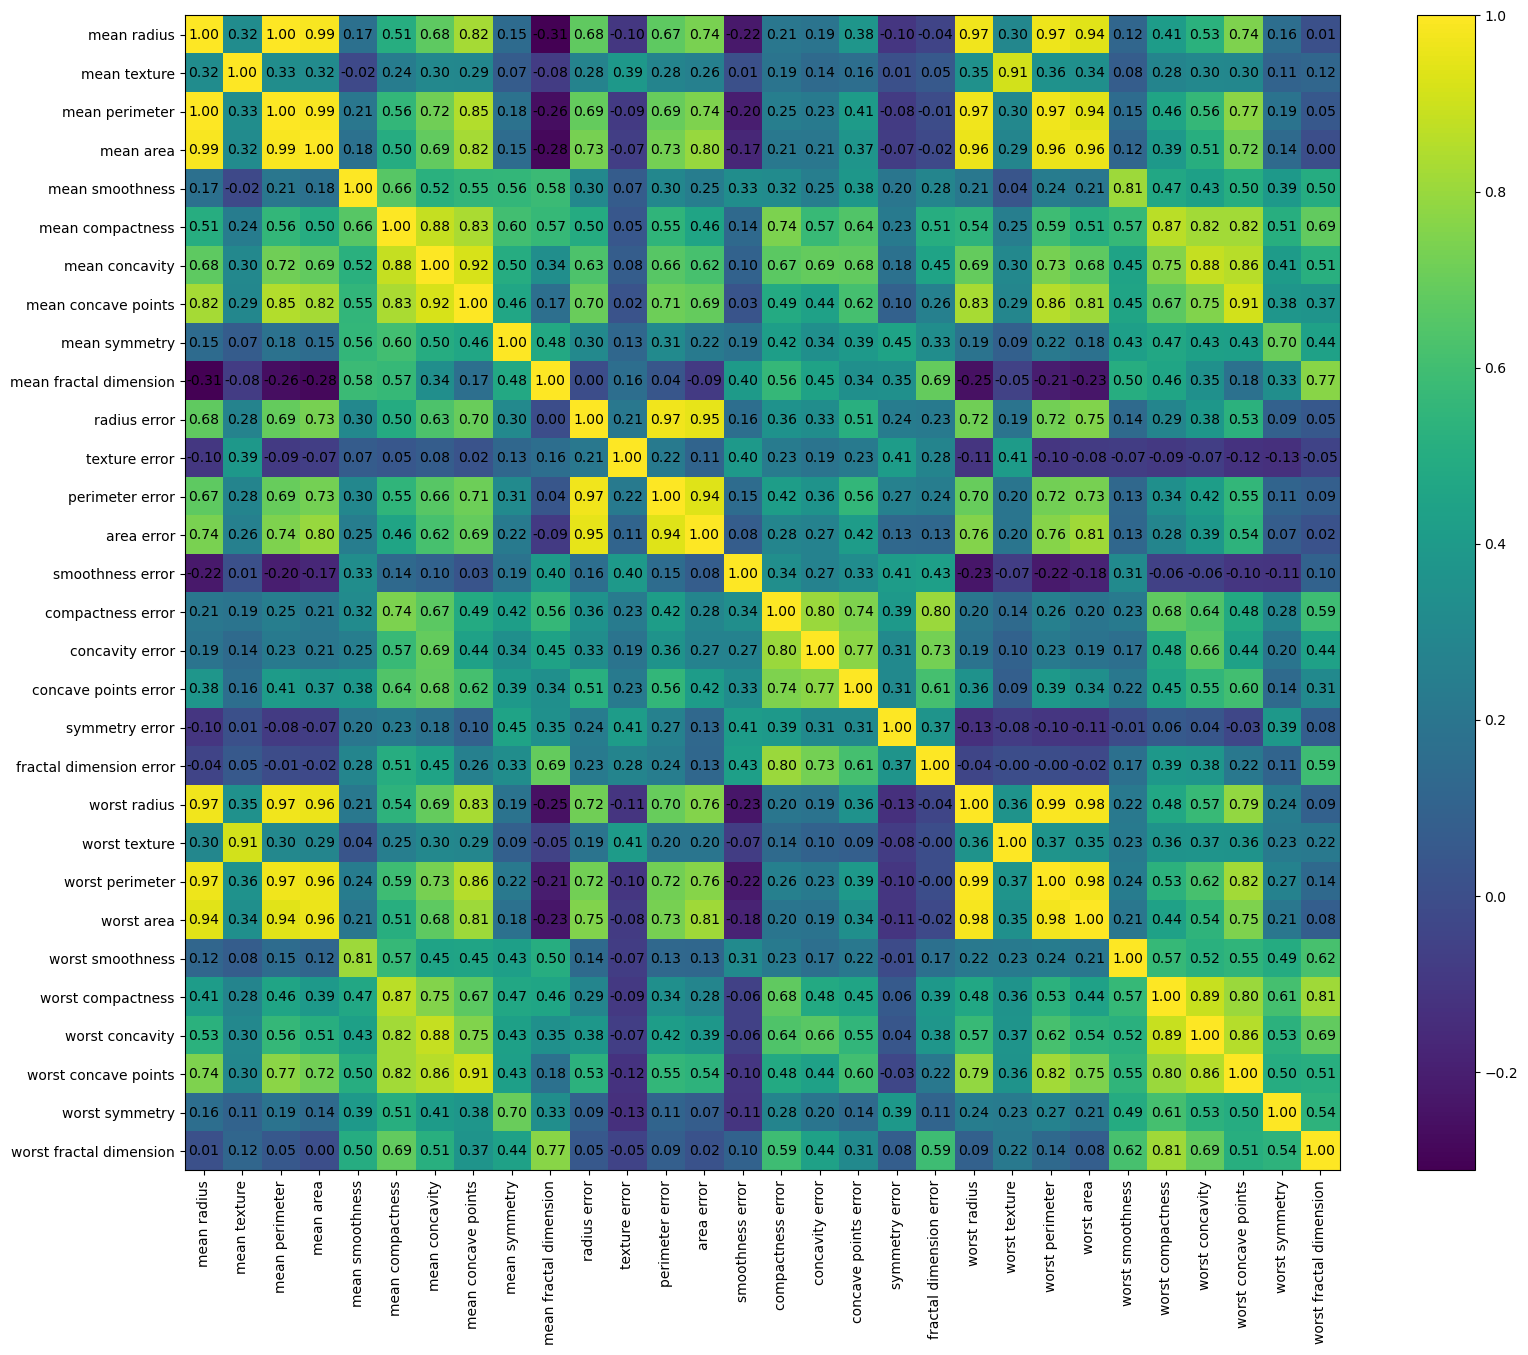

In [3]:

def generate_heatmap(feature_matrix):

    # Select all features for correlation calculation excluding the class vector column
    selected_features = feature_matrix.columns[:-1]

    # Calculate the correlation matrix
    corr_matrix = feature_matrix[selected_features].corr()

    # create heatmap of all correlations with values in the square of each heatmap cell
    plt.figure(figsize=(20, 15))
    plt.imshow(corr_matrix, cmap="viridis")
    plt.xticks(range(len(selected_features)), selected_features, rotation=90)
    plt.yticks(range(len(selected_features)), selected_features)

    # Display the correlation values in each cell
    for i in range(len(selected_features)):
        for j in range(len(selected_features)):
            plt.text(i, j, f"{corr_matrix.iloc[i, j]:.2f}", ha="center", va="center")
            
    # print correlations between all features in the matrix that are greater than 0.9
    for i in range(len(selected_features)):
        for j in range(i + 1, len(selected_features)):
            if corr_matrix.iloc[i, j] > 0.9:
                print(f"{selected_features[i]} and {selected_features[j]} have correlation {corr_matrix.iloc[i, j]}")

    plt.colorbar()
    plt.show()

generate_heatmap(feature_matrix_x)

### 1.2 Post Feature Dropping Heatmap and Training/Testing Split
---
Here the highly correlated features from 1.1 are dropped from the filtered dataset and then another heatmap of correlations is generated to demonstrate the lack of over 0.9 correlated feature pairs.<br> The dataset is also split with random state 123 into an 85/15 training/testing split where the shape is printed to check that it follows this 85/15 split.

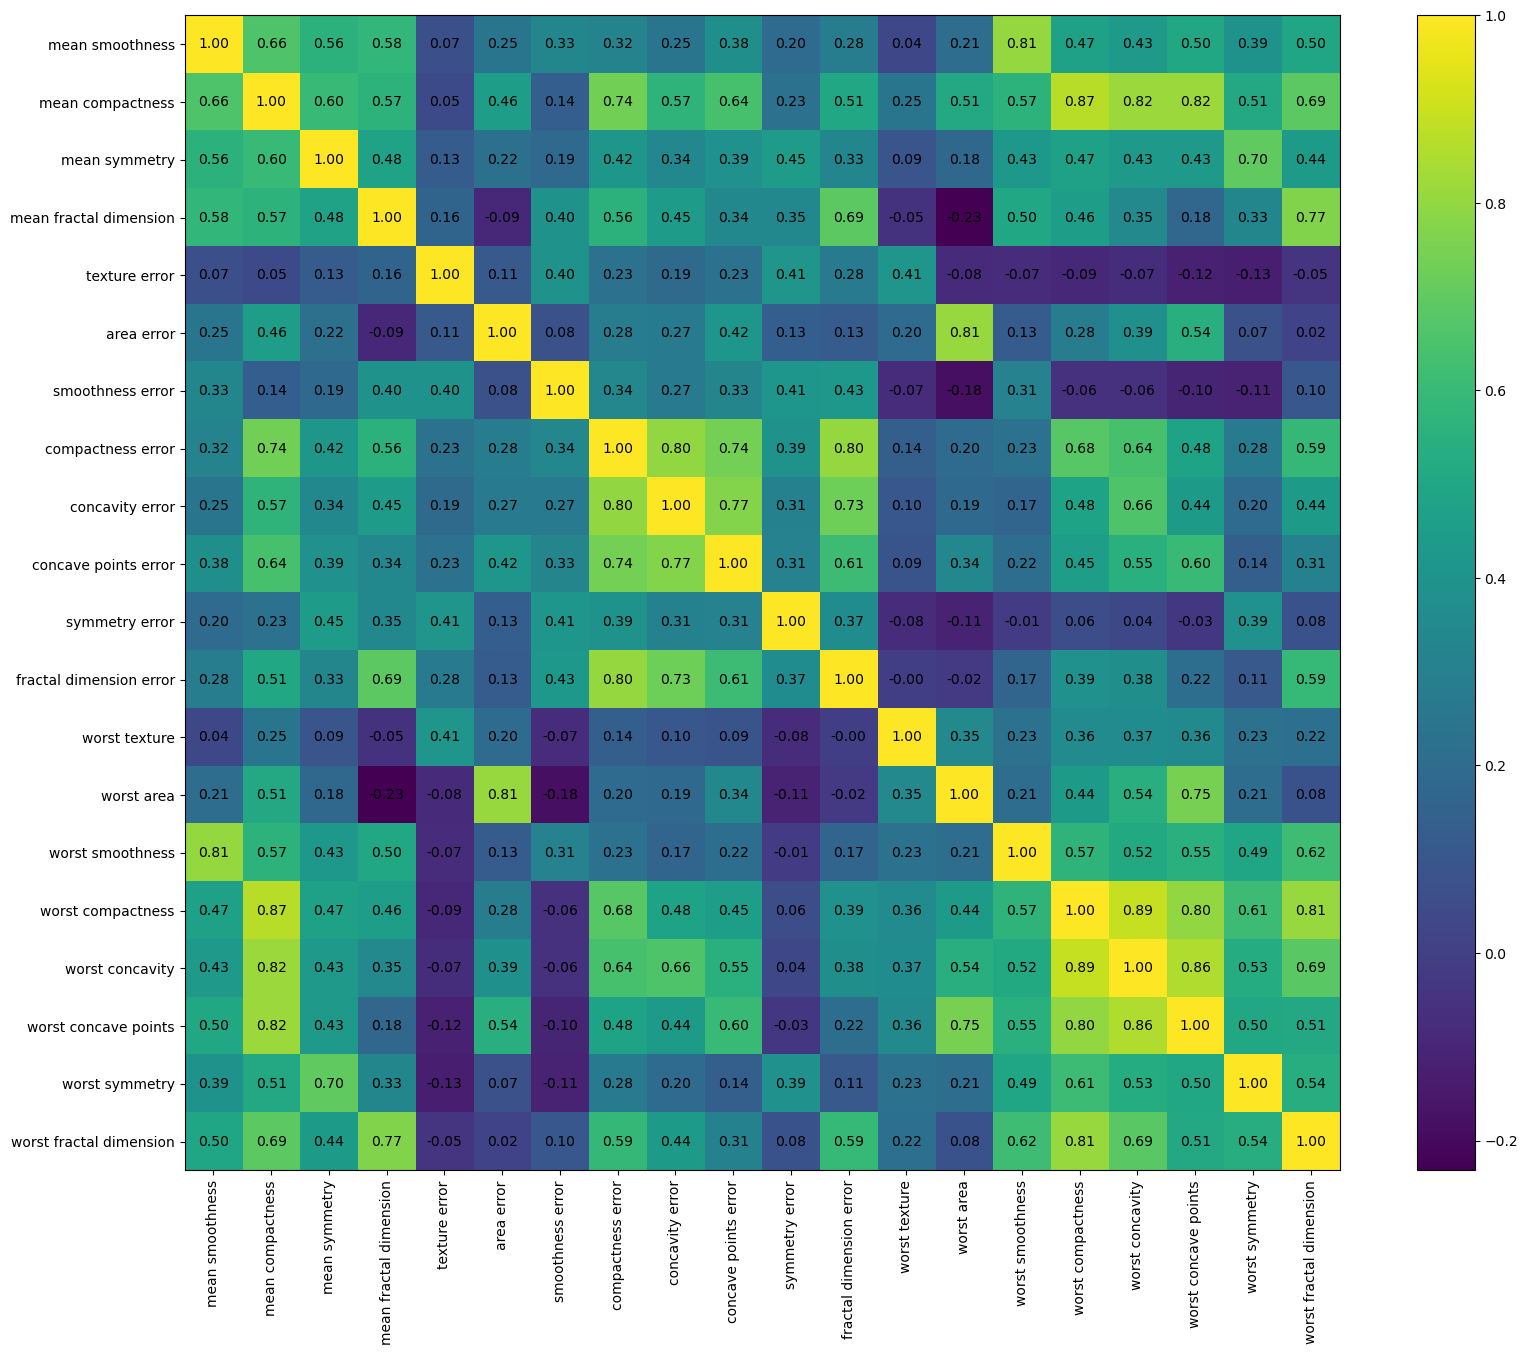

(483, 20)
(86, 20)
(483,)
(86,)


In [4]:
# Drop the features with high correlation
columns = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean concavity', 'mean concave points', 'radius error', 'perimeter error', 'worst radius', 'worst perimeter']
feature_matrix_x_filtered = feature_matrix_x.drop(columns=columns)

# Generate new heatmap with the filtered feature matrix
generate_heatmap(feature_matrix_x_filtered)


# Prepare dataset into x and y to be split into training and test sets
x = feature_matrix_x_filtered.drop(columns='class_vector_y')
y = feature_matrix_x_filtered['class_vector_y']

# Split the filtered feature matrix and the class vector into training and test sets
feature_matrix_x_train, feature_matrix_x_test, class_vector_y_train, class_vector_y_test = train_test_split(x, y, test_size= 0.15, random_state=123)

# Check that the shape follows an 85/15 split
print(feature_matrix_x_train.shape)
print(feature_matrix_x_test.shape)
print(class_vector_y_train.shape)
print(class_vector_y_test.shape)


### 1.3 Decision Tree Classifier with Default HyperParameters
---
Here a decision tree classifier is fitted to the filtered training data created in 1.2, then the accuracy scores for the testing and training data are calculated to be 1.0 and ~0.930 respectively. <br> This would indeed seem to indicate a mild overfitting issue as the classifier can perfectly predict the training data, but only 93% of the testing data. This indicates that the model is accounting for every data point in the training data including noise and outliers and as a result may be mildly overfitting. <br> This overfitting could be due to many things but I think the most prevalent contributor is the fact that we didn't undertake any data cleaning and as a result the model is training off of data with all noise and outliers still in the dataset. <br> However the model is still predicting at a high (93%) accuracy on the testing data so it is still generalising the underlying trend well and predicting unseen data with a high accuracy.

In [5]:
# Train a decision tree classifier using the default hyperparameters
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(feature_matrix_x_train, class_vector_y_train)

# Make predictions on the training and test sets
y_train_pred = dt_classifier.predict(feature_matrix_x_train)
y_test_pred = dt_classifier.predict(feature_matrix_x_test)

# Calculate the accuracy scores for the training and test sets
train_accuracy = accuracy_score(class_vector_y_train, y_train_pred)
test_accuracy = accuracy_score(class_vector_y_test, y_test_pred)

# Compare the accuracy scores for the training and test sets
print("Training set accuracy is", train_accuracy)
print("Test set accuracy is", test_accuracy)

Training set accuracy is 1.0
Test set accuracy is 0.9302325581395349


### 1.4 Display Decision Tree Classifier
---
Here the default hyperparameter decision tree classifier is visualised with a maxdepth of 3. <br> This visualisation can shed more light into the previously described overfitting issue, in this tree it can be seen that the model is most likely overfitting, the tree has many nodes with only a single data point and has many exceptions in the deeper nodes of the tree. <br> This indicates that the model is capturing noise and potentially outliers in the training data and as a result is overfitting. Additionally we can only see up until depth 3 in this diagram and there are more unkown layers to the decision tree which would suggest that the single data point nodes and exceptions made to accomodate noise would continue further. <br> This combined with the fact that the model is predicting at a 93% accuracy on the testing data compared with 100% on the training data confirms the mild overfitting issue going on.

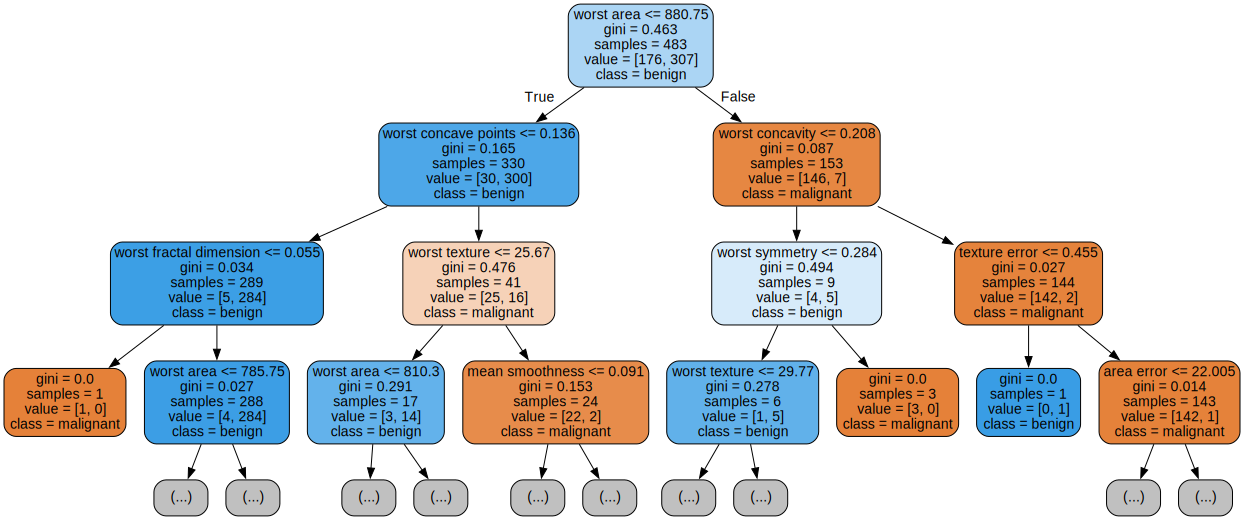

In [6]:
# Create decision tree graph and save to file function so that it can be called for every decision tree classifier trained
def display_tree(dt_classifier, feature_matrix_x_filtered, filename):
    
    export_graphviz(
        dt_classifier,
        out_file=filename,
        feature_names=feature_matrix_x_filtered.drop(columns='class_vector_y').columns,
        class_names=data.target_names,
        rounded=True,
        filled=True,
        max_depth=3
    )

# Display the tree
display_tree(dt_classifier, feature_matrix_x_filtered, "breast_cancer_tree_default.dot")
Source.from_file("breast_cancer_tree_default.dot")

### 1.5 Max Depth Limited Decision Tree Classifier
---
Here a new decision tree clasifier is trained with a max_depth hyperparameter set to 3. It can be seen that this restriction simplifies the decision tree classifier preventing some of the noise and outlier capturing that was happening in section <i>1.4</i>. <br> With a training set accuracy of ~97.7% and a testing set accuracy of ~ 94.2% we can clearly see that this model preforms better than the default hyperparameter decision tree classifier (93%) on unseen testing data and slightly worse (100%) on testing data. This would indicate that the overfitting issue is reducing as the model is no longer perfectly predicting the training data and is actually performing better on unseen testing data. This indicates that the model is generalising the underlying trend better and is not overfitting as much as the previous unrestricted depth model likely due to the restriction in depth not allowing the model to encapsulate all the noise and outliers in the testing set. <br> This reduction in complexity and overfitting is also evident in the visualisation of the decision tree classifier, the tree is much simpler and has less nodes including no children that could encapsulate more outliers as seen in the diagram in section <i>1.4</i>. <br> This combined with the fact that the model is predicting at a 94% accuracy on the testing data compared with 97% on the training data confirms the reduction in overfitting issue.

Training set accuracy (max_depth=3): 0.9772256728778468
Test set accuracy (max_depth=3): 0.9418604651162791


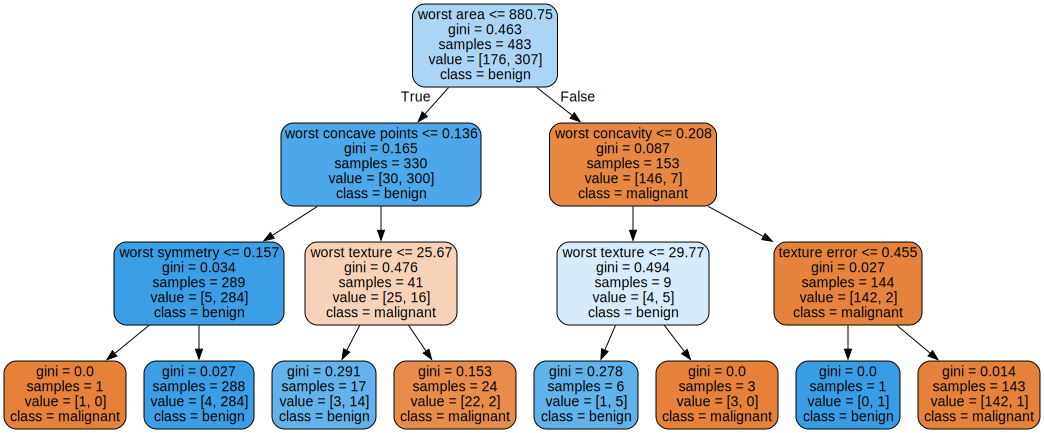

In [7]:
# Construct the second decision tree classifier with the max depth hyperparameter set to 3
dt_classifier_max_depth_3 = DecisionTreeClassifier(max_depth=3)

# Train the classifier using the training data
dt_classifier_max_depth_3.fit(feature_matrix_x_train, class_vector_y_train)

# Perform predictions on the training set and the test set
y_train_pred_max_depth_3 = dt_classifier_max_depth_3.predict(feature_matrix_x_train)
y_test_pred_max_depth_3 = dt_classifier_max_depth_3.predict(feature_matrix_x_test)

# Calculate accuracy scores for the training set and the test set
train_accuracy_max_depth_3 = accuracy_score(class_vector_y_train, y_train_pred_max_depth_3)
test_accuracy_max_depth_3 = accuracy_score(class_vector_y_test, y_test_pred_max_depth_3)

# Print the accuracy scores
print(f"Training set accuracy (max_depth=3): {train_accuracy_max_depth_3}")
print(f"Test set accuracy (max_depth=3): {test_accuracy_max_depth_3}")

# Display the tree
display_tree(dt_classifier_max_depth_3, feature_matrix_x_filtered, "breast_cancer_tree_max_depth_3.dot")
Source.from_file("breast_cancer_tree_max_depth_3.dot")

### 1.6 Min Samples Split Decision Tree Classifier
---
Here another decision tree classifier is generated with the hyperparameter min_samples_split being set to 5. This min_samples_split Hyperparameter changes the tree to continue expanding nodes until all leaves are pure or until each node contains less than 5 samples. This is very similar to the default decision tree classifier which defaults to expanding nodes until pure or until less than 2 samples in each node. <br> The similarity to the default decision tree classifier can be seen in the results. This min samples split limited decision tree classifier has a testing accuracy of ~99.4% and a training accuracy of ~93.0%. These are very similar numbers to the default decision tree classifier ~(100% and 93.0% respectively) and slightly worse than the max depth limited tree ~(97.7% and 94.2% respectively). <br> These accuracy values make sense considering the structure of the tree is very similar to the default tree, the overfitting problem still exists in this case with an almost perfect testing accuracy compared to a worse training accuracy. This is also to be expected as like in the default decision tree classifier the tree continues expanding until nodes are pure or contain 5 samples allowing the tree to continue to grow more complex containing many single element nodes and capture alot of the noise and outliers in the training set. This increase in depth and complexity results in noise and outliers being encapsulated and as a result theres a higher training set accuracy and a lower test set accuracy than the max_depth limited decision tree classifier and a slightly better accuracy than the default tree as the complexity is more limited than the default hyperparameter of 2 minimum samples.

Training set accuracy with min_samples_split=5 0.9937888198757764
Test set accuracy with min_samples_split=5: 0.9302325581395349


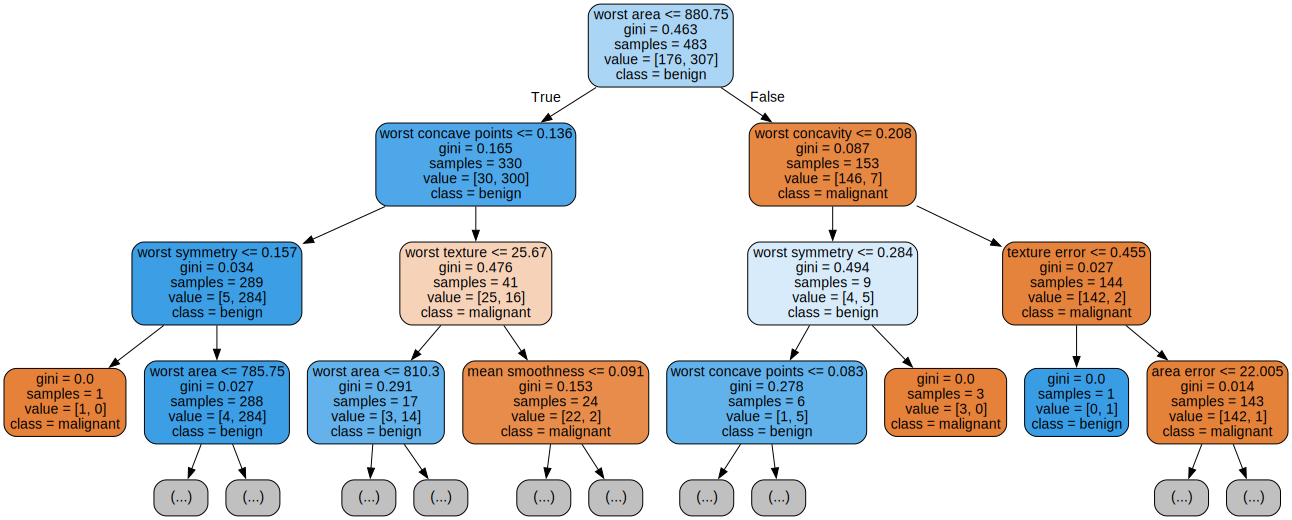

In [8]:
# Train a decision tree classifier with min_samples_split=5
dt_classifier_min_samples_split_5 = DecisionTreeClassifier(min_samples_split=5)
dt_classifier_min_samples_split_5.fit(feature_matrix_x_train, class_vector_y_train)

# Make predictions for both the training and test sets
y_train_pred_min_samples_split_5 = dt_classifier_min_samples_split_5.predict(feature_matrix_x_train)
y_test_pred_min_samples_split_5 = dt_classifier_min_samples_split_5.predict(feature_matrix_x_test)

# Calculate the accuracy scores for the training and test sets
train_accuracy_min_samples_split_5 = accuracy_score(class_vector_y_train, y_train_pred_min_samples_split_5)
test_accuracy_min_samples_split_5 = accuracy_score(class_vector_y_test, y_test_pred_min_samples_split_5)

print("Training set accuracy with min_samples_split=5", train_accuracy_min_samples_split_5)
print("Test set accuracy with min_samples_split=5:", test_accuracy_min_samples_split_5)

# Display the tree
display_tree(dt_classifier_min_samples_split_5, feature_matrix_x_filtered, "breast_cancer_tree_min_samples_split_5.dot")
Source.from_file("breast_cancer_tree_min_samples_split_5.dot")

### 1.7 Min Samples Leaf Decision Tree Classifier
---
Here another decision tree classifier is generated with the hyperparameter min_samples_leaf being set to 5. This min_samples_leaf Hyperparameter changes the tree to limit expanding as nodes will be considered leaf nodes when there are 5 or less samples in the node compared to the default 1. <br> This min samples leaf decision tree classifier has a testing accuracy of ~96.9% and a training accuracy of ~93.0%. These are similar numbers to the default decision tree classifier ~(100% and 93.0% respectively), slightly worse than the max depth limited tree ~(97.7% and 94.2% respectively) and very similar to the min_samples_split decision tree classifier (99.4% and 93.0% respectively). <br> The effect of the min_samples_leaf can be seen in the diagram below, on the right side where worst concavitiy <= 0.208 gets split into gini and worst concave points in previous trees this would continue splitting into a 3 and 6 sample node however due to the minimum sample size of a node needing to be 5 this split does not happen. <br> This causes a reduction in the complexity and capturing of outliers in the model allowing for less overfitting than the default decision tree and a smoothing affect on the models output. <br> The lower test set accuracy compared to the training set accuracy suggests that the overfitting problem is still somewhat present in this model however it is a lower discrepancy than the min samples and default model suggesting that those models increased complexity and capturing of outliers only serves to increase their training set accuracy without benefitting the test set accuracy.

Training set accuracy with min_samples_leaf=5 0.968944099378882
Test set accuracy with min_samples_leaf=5 0.9302325581395349


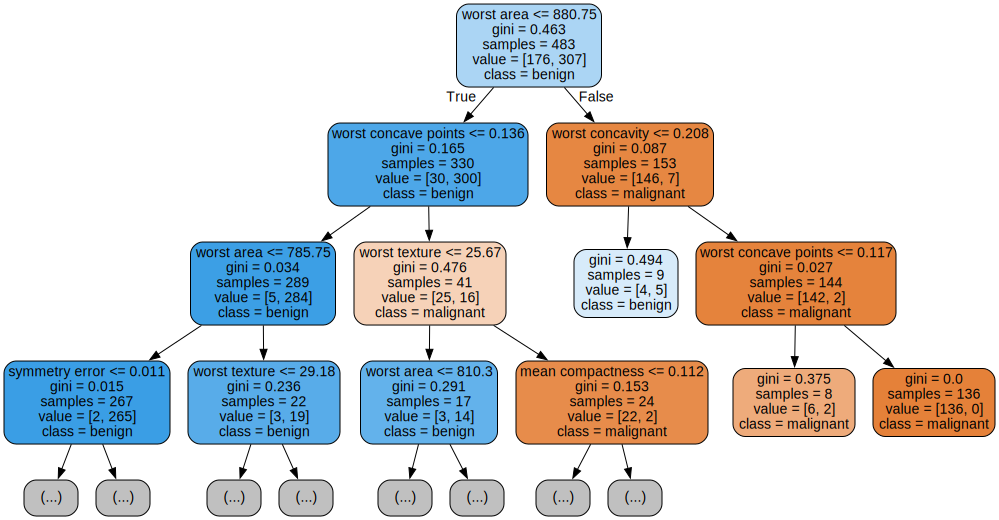

In [9]:
# Train a decision tree classifier with min_samples_leaf=5
dt_classifier_min_samples_leaf_5 = DecisionTreeClassifier(min_samples_leaf=5)
dt_classifier_min_samples_leaf_5.fit(feature_matrix_x_train, class_vector_y_train)

# Make predictions for both the training and test sets
y_train_pred_min_samples_leaf_5 = dt_classifier_min_samples_leaf_5.predict(feature_matrix_x_train)
y_test_pred_min_samples_leaf_5 = dt_classifier_min_samples_leaf_5.predict(feature_matrix_x_test)

# Calculate the accuracy scores for the training and test sets
train_accuracy_min_samples_leaf_5 = accuracy_score(class_vector_y_train, y_train_pred_min_samples_leaf_5)
test_accuracy_min_samples_leaf_5 = accuracy_score(class_vector_y_test, y_test_pred_min_samples_leaf_5)

print("Training set accuracy with min_samples_leaf=5", train_accuracy_min_samples_leaf_5)
print("Test set accuracy with min_samples_leaf=5", test_accuracy_min_samples_leaf_5)

# Display the tree
display_tree(dt_classifier_min_samples_leaf_5, feature_matrix_x_filtered, "breast_cancer_tree_min_samples_leaf_5.dot")
Source.from_file("breast_cancer_tree_min_samples_leaf_5.dot")

### 1.8 Best Combination of Hyperparameters
---
Here the best combination of the three hyperparameters is found by gridsearching with 3-fold cross-validation. The best combination of hyperparameters is found to be max_depth=14, min_samples_leaf=1 and min_samples_split=12. With a 3-fold cross-validated accuracy of ~93.6%. These hyperparameters are similar to the ones used previously with a 1 higher max_depth than in <i>1.5</i>, a 3 higher min_samples_split than <i>1.6</i> and the same value of min_samples_leaf as <i>1.7</i>. <br> This suggests that our earlier discussions were on the money with the best combination of hyperparameters causing a reduction in complexity compared to the previous models. This reduction in complexity by limiting the depth and the samples required for a split helps reduce overfitting and improve accuracy on the unseen testing data by capturing the underlying trend better. These cross-validated chosen hyperparameters provide a good balance between complexity and generalisation of the underlying trend showing the benefit to combining these methods to reduce the complexity of the model. <br> <i>(*Note these values seem to change every time I close the kernel and rerun the code but they are always around 4-1-12 or 8-1-8 for the hyperparameters)

In [10]:
# Define the hyperparameters and their possible values
param_grid = {
    'max_depth': list(range(2, 21, 2)),
    'min_samples_split': list(range(2, 51, 2)),  
    'min_samples_leaf': list(range(1, 51, 2))     
}

# Create the decision tree classifier
dt_classifier_best = DecisionTreeClassifier()

# Create the grid search with 3-fold cross-validation
grid_search = GridSearchCV(dt_classifier_best, param_grid, cv=3, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(feature_matrix_x_train, class_vector_y_train)

# Get the best hyperparameters found
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best hyperparameters found:")
print(best_params)
print(f"Best mean cross-validated accuracy: {best_score}")

Best hyperparameters found:
{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 8}
Best mean cross-validated accuracy: 0.9337474120082816


### 1.9 Conclusion
---
Here we calcualte the training and test set results for the best hyperparameters found in <i>1.8</i> above of max_depth 4, min_samples_leaf 1 and min_samples_split 8. These best hyperparameters have a training set accuracy of ~98.1% and a testing set accuracy of ~94.2%. This is the best of the different hyperparameters we looked at with a tied best testing set accuracy with the max_depth = 5 and a slightly higher testing set accuracy. <br> Looking at the two best performing models in more depth namely their confusion matrices and reports we can see that both models are very similar in performance. The gridsearch selected model has a slightly better confusion matrix for training data with two more true labels for malignant (0) classification than the max depth model, although this is a very small difference and both models have an identical testing data confusion matrix. 
<br> The classification report for the gridsearch selected model also shows a slightly better performance with a higher precision for the benign (1) class and a higher recall for the malignant (0) class in the testing report. Considering the context of diagnosing breast cancer the slightly higher recall of the gridsearch model would be favoured as false negatives are very costly in this case requiring a tissue sample for confirmation which is an invasive procedure. <br> Due to the dangerous nature of the cancers that the model is trying to predict even the small differences are important and as a result the gridsearch chosen hyperparameter model is the best option.

Training set accuracy is: 0.9813664596273292
Test set accuracy is: 0.9418604651162791


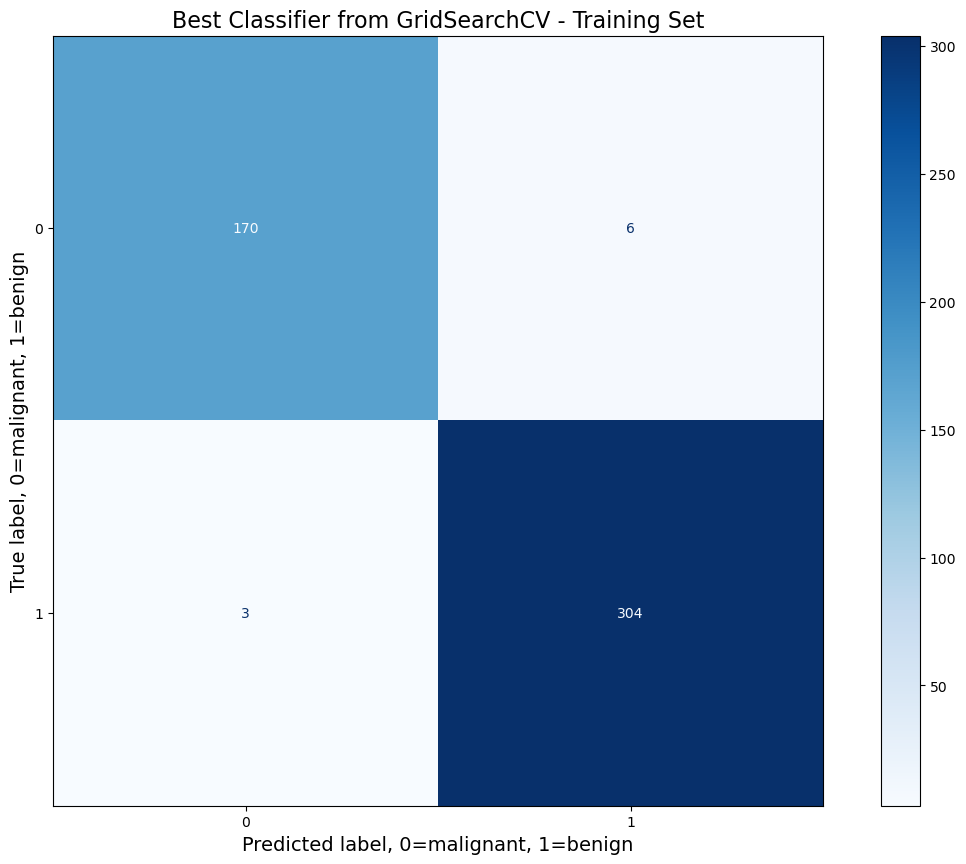

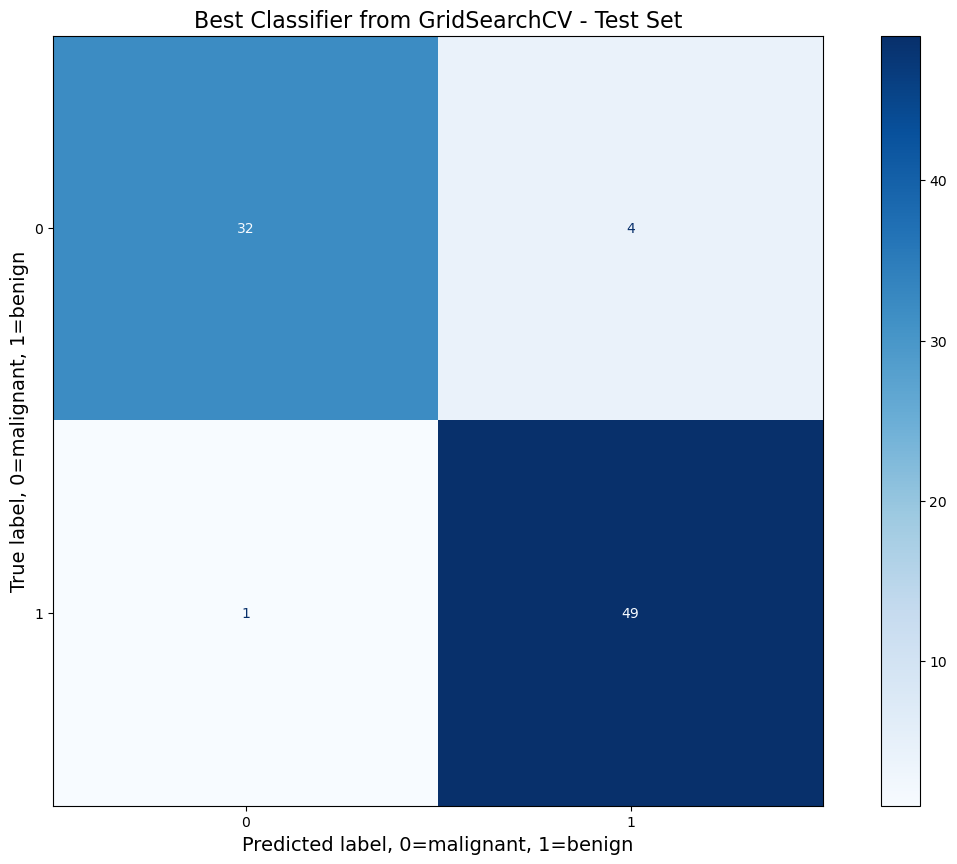

Best Classifier from GridSearchCV - Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       176
           1       0.98      0.99      0.99       307

    accuracy                           0.98       483
   macro avg       0.98      0.98      0.98       483
weighted avg       0.98      0.98      0.98       483

Best Classifier from GridSearchCV - Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       0.92      0.98      0.95        50

    accuracy                           0.94        86
   macro avg       0.95      0.93      0.94        86
weighted avg       0.94      0.94      0.94        86





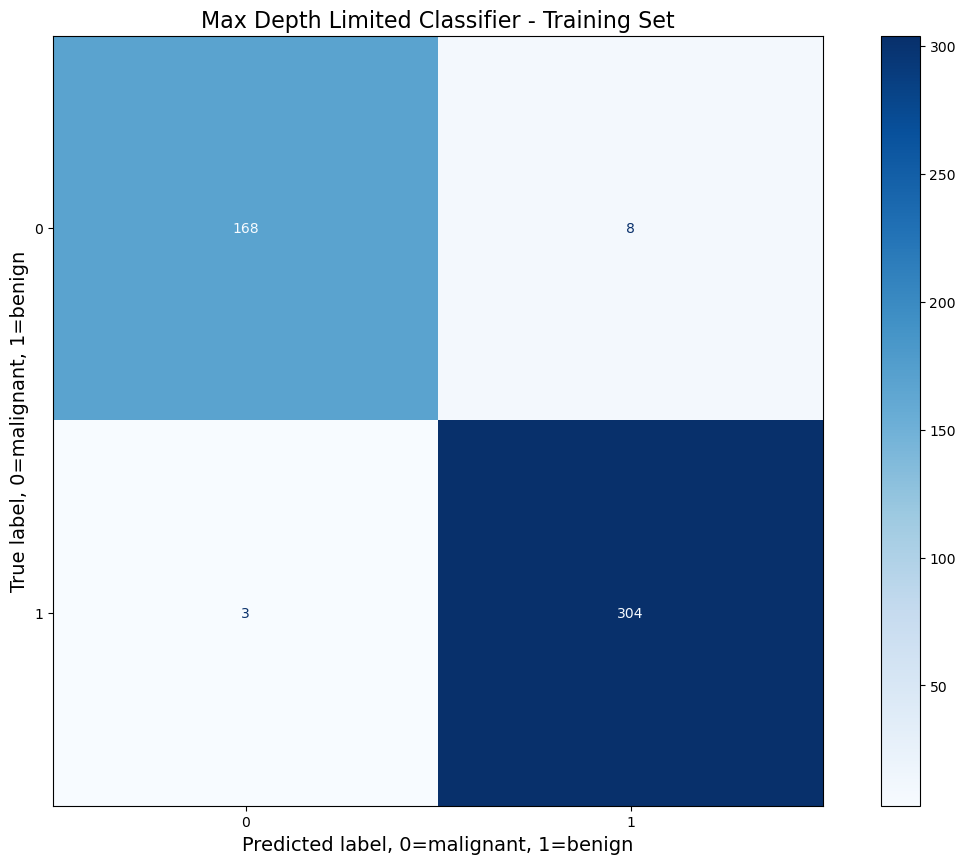

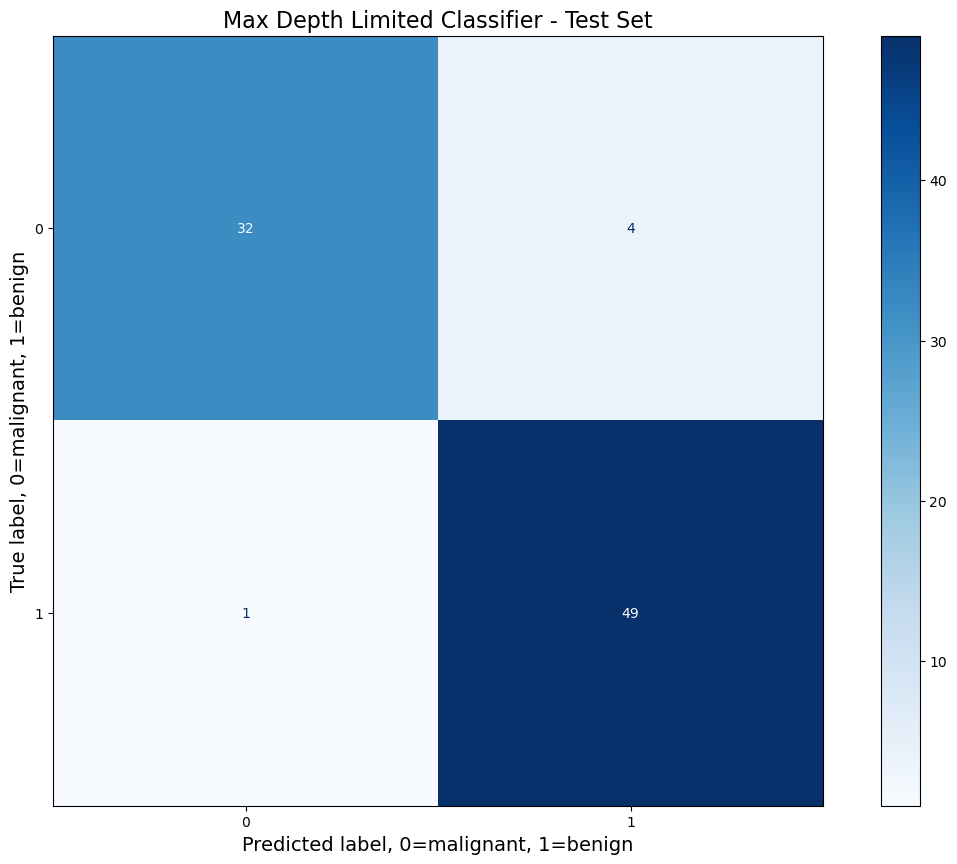

Max Depth Limited Classifier - Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       176
           1       0.97      0.99      0.98       307

    accuracy                           0.98       483
   macro avg       0.98      0.97      0.98       483
weighted avg       0.98      0.98      0.98       483

Max Depth Limited Classifier - Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       0.92      0.98      0.95        50

    accuracy                           0.94        86
   macro avg       0.95      0.93      0.94        86
weighted avg       0.94      0.94      0.94        86





In [11]:
# Train a decision tree classifier using the best hyperparameters found
best_dt_classifier = DecisionTreeClassifier(max_depth=4, min_samples_leaf=1, min_samples_split=8)
best_dt_classifier.fit(feature_matrix_x_train, class_vector_y_train)

# Make predictions on the training and test sets
y_train_pred = best_dt_classifier.predict(feature_matrix_x_train)
y_test_pred = best_dt_classifier.predict(feature_matrix_x_test)

# Calculate the accuracy scores for the training and test sets
train_accuracy = accuracy_score(class_vector_y_train, y_train_pred)
test_accuracy = accuracy_score(class_vector_y_test, y_test_pred)

# Compare the accuracy scores for the training and test sets
print(f"Training set accuracy is: {train_accuracy}")
print(f"Test set accuracy is: {test_accuracy}")

def plot_confusion_matrix(cm, title):
    fig, ax = plt.subplots(figsize=(15, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(title, fontsize=16)
    plt.xlabel('Predicted label, 0=malignant, 1=benign', fontsize=14)
    plt.ylabel('True label, 0=malignant, 1=benign', fontsize=14)
    plt.show()

# Classifier names for titles
classifier_names = [
    "Best Classifier from GridSearchCV",
    "Max Depth Limited Classifier",
]

# List of classifiers
classifiers = [
    best_dt_classifier,
    dt_classifier_max_depth_3,
]

for name, classifier in zip(classifier_names, classifiers):
    # Calculate confusion matrices
    train_confusionmatrix = confusion_matrix(class_vector_y_train, classifier.predict(feature_matrix_x_train))
    test_confusionmatrix = confusion_matrix(class_vector_y_test, classifier.predict(feature_matrix_x_test))

    # Plot confusion matrices
    plot_confusion_matrix(train_confusionmatrix, f'{name} - Training Set')
    plot_confusion_matrix(test_confusionmatrix, f'{name} - Test Set')

    # Print classification reports
    print(f"{name} - Training Set Classification Report:")
    print(classification_report(class_vector_y_train, classifier.predict(feature_matrix_x_train)))
    print(f"{name} - Test Set Classification Report:")
    print(classification_report(class_vector_y_test, classifier.predict(feature_matrix_x_test)))
    print("\n")


## 2 Concrete Dataset

### 2.0 Concrere Slump Test Data Loading & Visualisation
---
Here the concrete slump data is loaded in and then visualised with histograms of each feature to provie a greater understanding of the data. Then the correlations between each feature and the target variable are plotted to determine if any features can be dropped. <br> It can be seen from this plot that all features have some form of correlation to the target variable and as a result no features should be dropped.

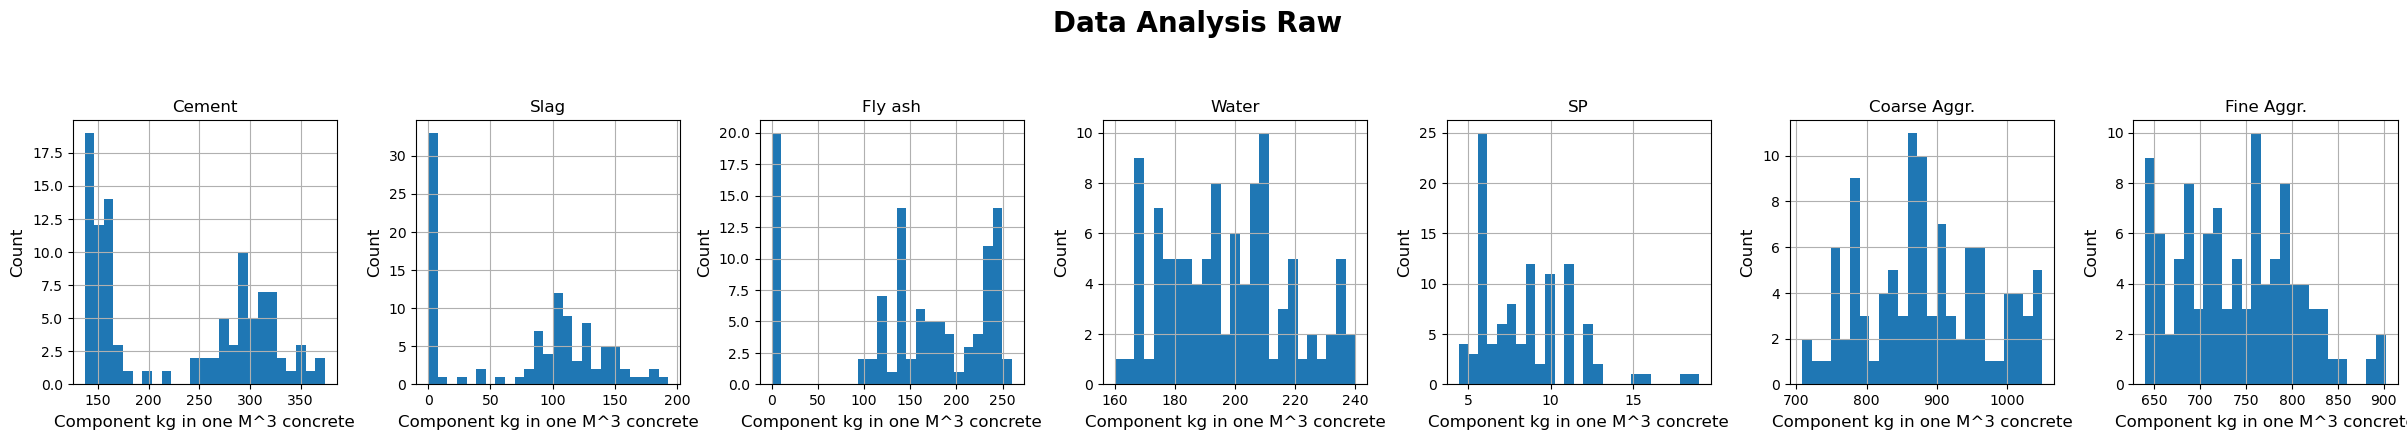

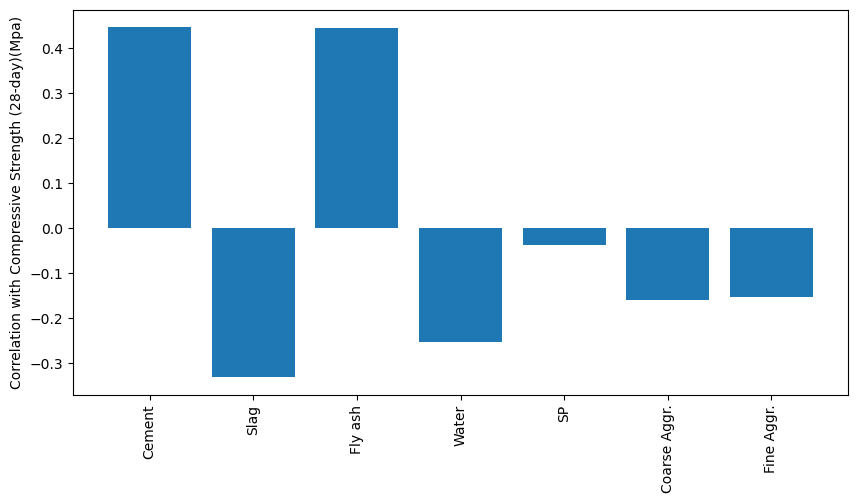

In [12]:
# Load in slump data
slump_data_df = pd.read_csv("slump_test.data", index_col=0)

# plot histograms of all the features in the data
def slump_data_histogram(df):
    column_names = df.columns[:7].to_list()
    ax = df.hist(column = column_names,bins=25, figsize=(30,5),layout=(1,7))
    ax = ax.flatten()
    for i,axis in enumerate(ax):
        axis.set_xlabel("Component kg in one M^3 concrete", labelpad=5, size=12)
        axis.set_ylabel("Count", labelpad=5, size=12)
        axis.title.set_text(column_names[i])
        axis.set_aspect(1./axis.get_data_ratio())
    plt.suptitle('Data Analysis Raw',fontsize=20,weight='bold')
    plt.subplots_adjust(hspace=0.1,wspace=0.3)
    plt.show()

# Drop the non essential target columns slump and fglow and plot correlations to see if other features can be dropped
def clean_data_and_plot_correlations(data):
    # Drop the unnecessary output columns
    data_clean = data.drop(columns=['SLUMP(cm)', 'FLOW(cm)'])

    # Calculate the correlation matrix
    corr_matrix = data_clean.corr()

    # Extract correlations with the target variable
    target_correlations = corr_matrix['Compressive Strength (28-day)(Mpa)'].drop('Compressive Strength (28-day)(Mpa)')
    
    # Plot the correlations
    plt.figure(figsize=(10, 5))
    plt.bar(np.arange(len(target_correlations)), target_correlations)
    plt.xticks(np.arange(len(target_correlations)), target_correlations.index, rotation=90)
    plt.ylabel('Correlation with Compressive Strength (28-day)(Mpa)')
    plt.show()
    
    return data_clean

slump_data_histogram(slump_data_df)
slump_df_cleaned = clean_data_and_plot_correlations(slump_data_df)




### 2.1 Scaling and Voting Regressor
---
Here we prepare the data to be used in our voting regressor by first splitting the dataset into our feature matrix x and our class variable y and then using train_test_split to do an 80/20 training/testing data set split. <br> After the data is split we scale the data using the standard scaler to ensure that all features are on the same scale and negate the impact of higher magnitude features seen in the histograms above. <br> Once the data is scaled we initialise our three individual estimators being
- linear regression
- svm regressor
- sgd regressor

Once these three individual estimators are initialised they are then combined into a voting regressor.

In [13]:
# Split the dataset into features (x) and target variable (y)
x = slump_df_cleaned.drop(columns=['Compressive Strength (28-day)(Mpa)'])
y = slump_df_cleaned['Compressive Strength (28-day)(Mpa)']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

# Scale the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Create the individual estimators
svm_regressor = LinearSVR(random_state=123)
linear_regressor = LinearRegression()
sgd_regressor = SGDRegressor(random_state=123)

# Combine the estimators into a Voting Regressor
estimators = [('svm', svm_regressor), ('linear', linear_regressor), ('sgd', sgd_regressor)]
voting_regressor = VotingRegressor(estimators)


### 2.2 Training Voting Regressor
---
Here we fit the three individual estimators from above and then the voting regressor and compare their predicted 28-day Compressive Strength values for the test set. <br> Their RMSE values are then calculated and finally the models predicted values are compared to the ground truth in the plot below. <br> From the RMSE it can be seen that the SGD Regressor is the best model currently with a RMSE of 3.18 compared to the Linear Regressor with a RMSE of 3.29 and the Linear Regressor with a RMSE of 3.93, the voting regressor has a RMSE of 3.40 meaning the combination of the three regressors did not result in a more accurate model. <br> This is also evident in the plot below where the goal is a perfectly diagonal line or 100 percent accuracy between predicted and ground truth values, here it can be seen that all the models do a reasonable job of this but the linear SVM is the worst being further away than the other three models by a fair amount.

Linear SVM Regressor RMSE: 3.93
Linear Regressor RMSE: 3.29
SGD Regressor RMSE: 3.18
Voting Regressor RMSE: 3.40


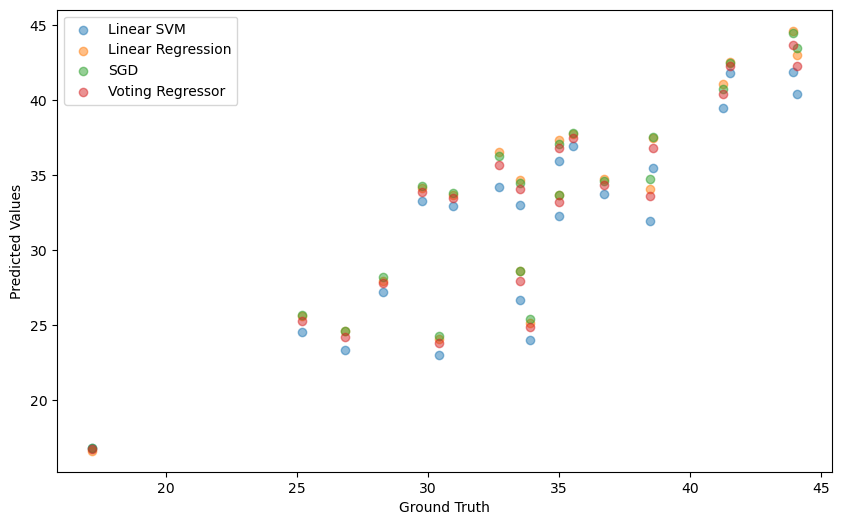

In [14]:
# Train the base estimators
svm_regressor.fit(x_train_scaled, y_train)
linear_regressor.fit(x_train_scaled, y_train)
sgd_regressor.fit(x_train_scaled, y_train)
voting_regressor.fit(x_train_scaled, y_train)

# Make predictions using the base estimators and the Voting Regressor
svm_predictions = svm_regressor.predict(x_test_scaled)
linear_predictions = linear_regressor.predict(x_test_scaled)
sgd_predictions = sgd_regressor.predict(x_test_scaled)
voting_predictions = voting_regressor.predict(x_test_scaled)

# Calculate RMSE for each model
svm_rmse = (mean_squared_error(y_test, svm_predictions,  squared=False))
linear_rmse = (mean_squared_error(y_test, linear_predictions, squared=False))
sgd_rmse = (mean_squared_error(y_test, sgd_predictions, squared=False))
voting_rmse =(mean_squared_error(y_test, voting_predictions, squared=False))

# Print RMSE values
print(f"Linear SVM Regressor RMSE: {svm_rmse:.2f}")
print(f"Linear Regressor RMSE: {linear_rmse:.2f}")
print(f"SGD Regressor RMSE: {sgd_rmse:.2f}")
print(f"Voting Regressor RMSE: {voting_rmse:.2f}")

# Plot predicted values against ground truth values for all test instances
plt.figure(figsize=(10, 6))
plt.scatter(y_test, svm_predictions, label="Linear SVM", alpha=0.5)
plt.scatter(y_test, linear_predictions, label="Linear Regression", alpha=0.5)
plt.scatter(y_test, sgd_predictions, label="SGD", alpha=0.5)
plt.scatter(y_test, voting_predictions, label="Voting Regressor", alpha=0.5)
plt.xlabel("Ground Truth")
plt.ylabel("Predicted Values")
plt.legend()
plt.show()

### 2.3 Hyperparameter Tuning
---
I chose the following hyperparameters to individually tune for each of the three models based on the sklearn docs and individual experimentation on what had the largest affect on the RMSE.
- SVM Regressor
    - C - Regularisation parameter
    - Max_iter - Maximum number of iterations before convergence
- Linear Regressor
    - Fit_intercept - Whether to calculate the intercept for this model
    - Copy_X - Whether to copy the X matrix or overwrite it
    - Positive - forces coefficients to be positive
- SGD Regressor
    - Alpha - Multiplier for the regularisation term higher stronger regularisation
    - Max_iter - Maximum number of iterations before convergence

A gridsearch was preformed on a range of possible values for each of the parameters above and then the best combination of parameters was chosen based on the lowest RMSE value the best hyperparameters and their resulting RMSE were as follows.
- SVM Regressor
    - C = 10
    - Max_iter = 10000
    - RMSE = 3.62
- Linear Regressor
    - Fit_intercept = True (default)
    - Copy_X = True (default)
    - Positive = False (default)
    - RMSE = 3.29
- SGD Regressor
    - Alpha = 0.001
    - Max_iter = 10000
    - RMSE = 3.18

These results are an improvement over the default RMSE values for the LinearSVM regressor and the voting regressor which had an RMSE of 3.35 as opposed to the 3.40 in section <i>2.2</i>, however there was no improvement in the RMSE value for the Linear or SGD Regressor models. <br> This is likely due to the default hyperparameters already representing the data well with a small RMSE to start with, in addition these results most likely could have been improved if I completed a more exhaustive search of the possible hyperparameters but the compute time was too long. <br> Inspecting the predicted values vs ground truth graph we can see this improvement in the models as the scatterplot is closer to the desired 45 degree diagonal line than in the previous section <i>2.2</i> indicating a slightly better fit to the data. <br> However this improvement after tuning the hyperparameters is minimal and the best performing model for predicting the 28-day Compressive Strength is still the SGD Regressor with a RMSE of 3.18.


Best SVM Regressor:
LinearSVR(C=10, max_iter=10000, random_state=123)

Best Linear Regressor:
LinearRegression()

Best SGD Regressor:
SGDRegressor(alpha=0.001, max_iter=10000, random_state=123) 

Tuned Linear SVM Regressor RMSE: 3.62
Tuned Linear Regressor RMSE: 3.29
Tuned SGD Regressor RMSE: 3.18
Tuned Voting Regressor RMSE: 3.35


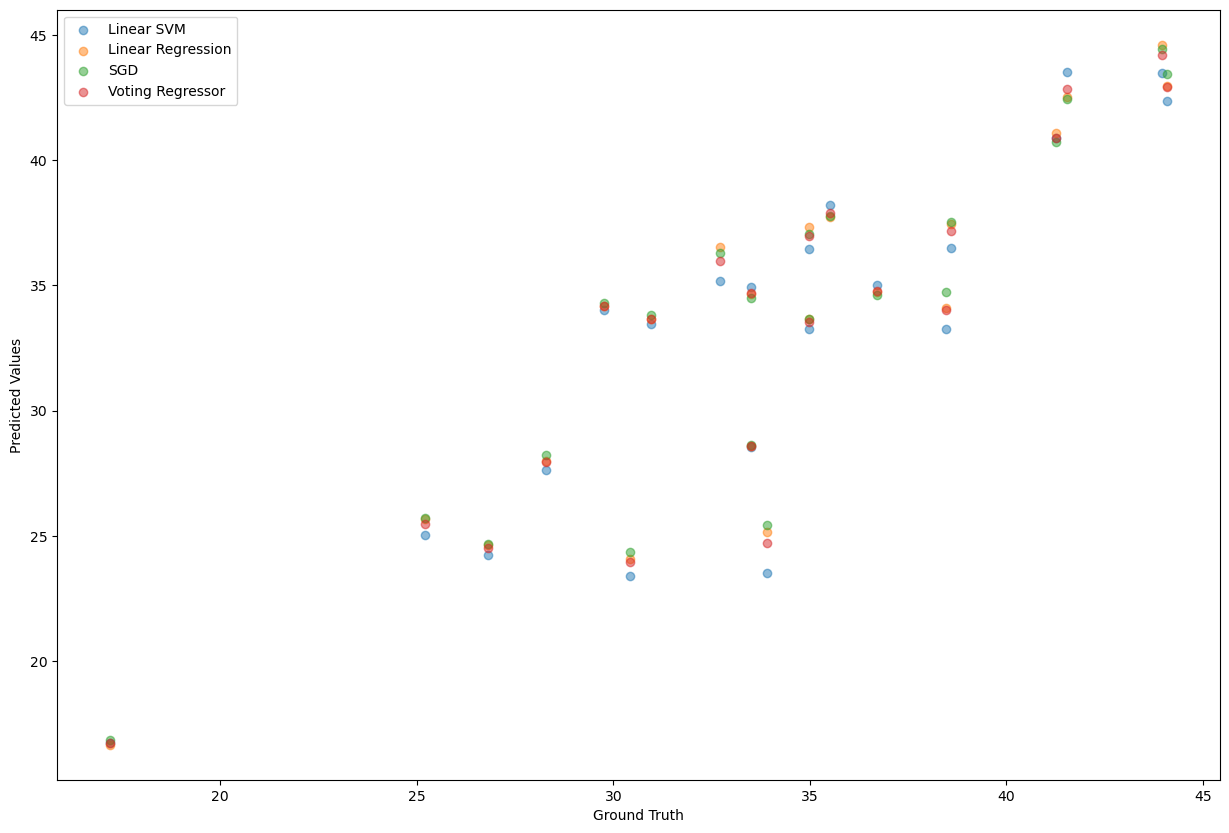

In [15]:
# Define the hyperparameter search space for each model
svm_params = {'C': [0.1, 1, 10], 'max_iter': [10000, 100000]}
linear_params = {'fit_intercept': [True, False], 'copy_X': [True, False], 'positive': [True, False]}
sgd_params = {'alpha': [0.0001, 0.001, 0.01], 'max_iter': [10000, 100000]}

# Perform GridSearchCV for each model
svm_grid = GridSearchCV(svm_regressor, svm_params, cv=3, scoring='neg_mean_squared_error')
linear_grid = GridSearchCV(linear_regressor, linear_params, cv=3, scoring='neg_mean_squared_error')
sgd_grid = GridSearchCV(sgd_regressor, sgd_params, cv=3, scoring='neg_mean_squared_error')

# Fit the GridSearchCV models to the training data
svm_grid.fit(x_train_scaled, y_train)
linear_grid.fit(x_train_scaled, y_train)
sgd_grid.fit(x_train_scaled, y_train)

# Get the best estimators from GridSearchCV
best_svm = svm_grid.best_estimator_
best_linear = linear_grid.best_estimator_
best_sgd = sgd_grid.best_estimator_

# Print the best estimators from GridSearchCv
print("Best SVM Regressor:")
print(best_svm)
print("\nBest Linear Regressor:")
print(best_linear)
print("\nBest SGD Regressor:")
print(best_sgd, "\n")

# Create a new Voting Regressor with tuned hyperparameters
tuned_estimators = [('svm', best_svm), ('linear', best_linear), ('sgd', best_sgd)]
tuned_voting_regressor = VotingRegressor(tuned_estimators)

# Fit the new Voting Regressor to the training data
tuned_voting_regressor.fit(x_train_scaled, y_train)

# Evaluate the models with tuned hyperparameters
tuned_svm_preds = best_svm.predict(x_test_scaled)
tuned_linear_preds = best_linear.predict(x_test_scaled)
tuned_sgd_preds = best_sgd.predict(x_test_scaled)
tuned_voting_preds = tuned_voting_regressor.predict(x_test_scaled)

# Calculate the RMSE for each model with tuned hyperparameters
tuned_svm_rmse = mean_squared_error(y_test, tuned_svm_preds, squared=False)
tuned_linear_rmse = mean_squared_error(y_test, tuned_linear_preds, squared=False)
tuned_sgd_rmse = mean_squared_error(y_test, tuned_sgd_preds, squared=False)
tuned_voting_rmse = mean_squared_error(y_test, tuned_voting_preds, squared=False)

# Print the RMSE for each model with tuned hyperparameters
print(f"Tuned Linear SVM Regressor RMSE: {tuned_svm_rmse:.2f}")
print(f"Tuned Linear Regressor RMSE: {tuned_linear_rmse:.2f}")
print(f"Tuned SGD Regressor RMSE: {tuned_sgd_rmse:.2f}")
print(f"Tuned Voting Regressor RMSE: {tuned_voting_rmse:.2f}")

# Plot predicted values against ground truth values for all test instances
plt.figure(figsize=(15, 10))
plt.scatter(y_test, tuned_svm_preds, label="Linear SVM", alpha=0.5)
plt.scatter(y_test, tuned_linear_preds, label="Linear Regression", alpha=0.5)
plt.scatter(y_test, tuned_sgd_preds, label="SGD", alpha=0.5)
plt.scatter(y_test, tuned_voting_preds, label="Voting Regressor", alpha=0.5)
plt.xlabel("Ground Truth")
plt.ylabel("Predicted Values")
plt.legend()
plt.show()

## 3 - Abalone Dataset


### 3.0 Abalone Data Loading & Visualisation
---
Here the abalone data is loaded into a dataframe and some basic visualisation by plotting histograms for each feature to get an understanding of the dataset. <br> It can be seen that all features are useful, the sex column was dropped as it was a text column and not numerical. The data was then split into feature matrix x and class variable y in an 85/15 testing/training split. <br> Finally it can be seen in the histograms that the features have a large variance in min max values and as a result will need to be scaled before the regressors are trained which is done at the last step (This might not be necessary as the majority of the regression models being trained are decision tree algorithms).

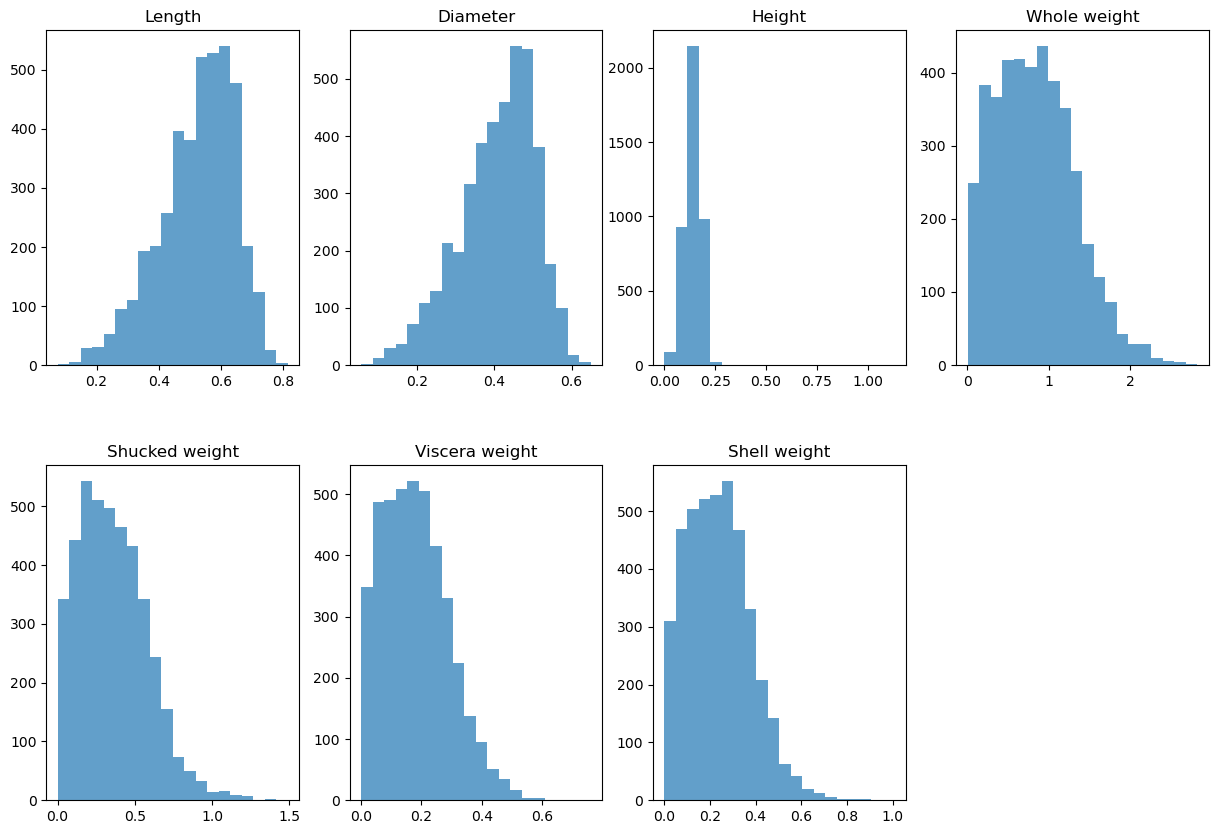

In [16]:
# Read in the abalone data csv
abalone_data_df = pd.read_csv("abalone.data", names=["Sex","Length","Diameter","Height","Whole weight","Shucked weight","Viscera weight","Shell weight","Rings"])

# Drop the text sex column from the dataframe
abalone_data_df = abalone_data_df.drop(columns='Sex')

# Define the number of rows and columns for the subplots
n_rows = 2
n_cols = 4

# Create a figure and axis
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))

# Define the feature names
feature_names = ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']

# Iterate through each feature and plot the histogram
for i, feature in enumerate(feature_names):
    row = i // n_cols
    col = i % n_cols
    axs[row, col].hist(abalone_data_df[feature], bins=20, alpha=0.7)
    axs[row, col].set_title(feature)

# Remove the last unused subplot
axs[-1, -1].axis('off')

# Add space between subplots
plt.subplots_adjust(hspace=0.3)

# Display the histograms
plt.show()

x = abalone_data_df.drop(columns=['Rings'])
y = abalone_data_df['Rings']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=123)

# Scale the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)



### 3.1 Errors as Function of Max Depth
---
Here the decision tree regressor is trained on the training data over a number of different max_depths using 3-fold cross-validation to tune the max_depth. Then the following errors are calculated.
- training errors
- cross-validation errors
- test errors

These three errors are calculated and then stored in lists so that they can be plotted at the end. In the plot it can be seen that initially as max_depth increases all three errors decrease this is to be expected as an increase in max_depth will increase the complexity of the model and it's ability to encapsulate the training data. However at around max_depth 6 the trend stops and the testing and cross validation error starts to increase again whilst the training error keeps going down. <br> This is most likely due to the model starting to get too complex at depths greater than 6 and as a result it starts to encapsulate more and more outliers and noise from the training data resulting in overfitting and a reduction in the training error but an increase in the testing and cross validation error as the underlying trend is being captured less effectively.
<br> As a result of this I would choose the value of max_depth that minimises the testing and cross validation error which would be max_depth = 6.

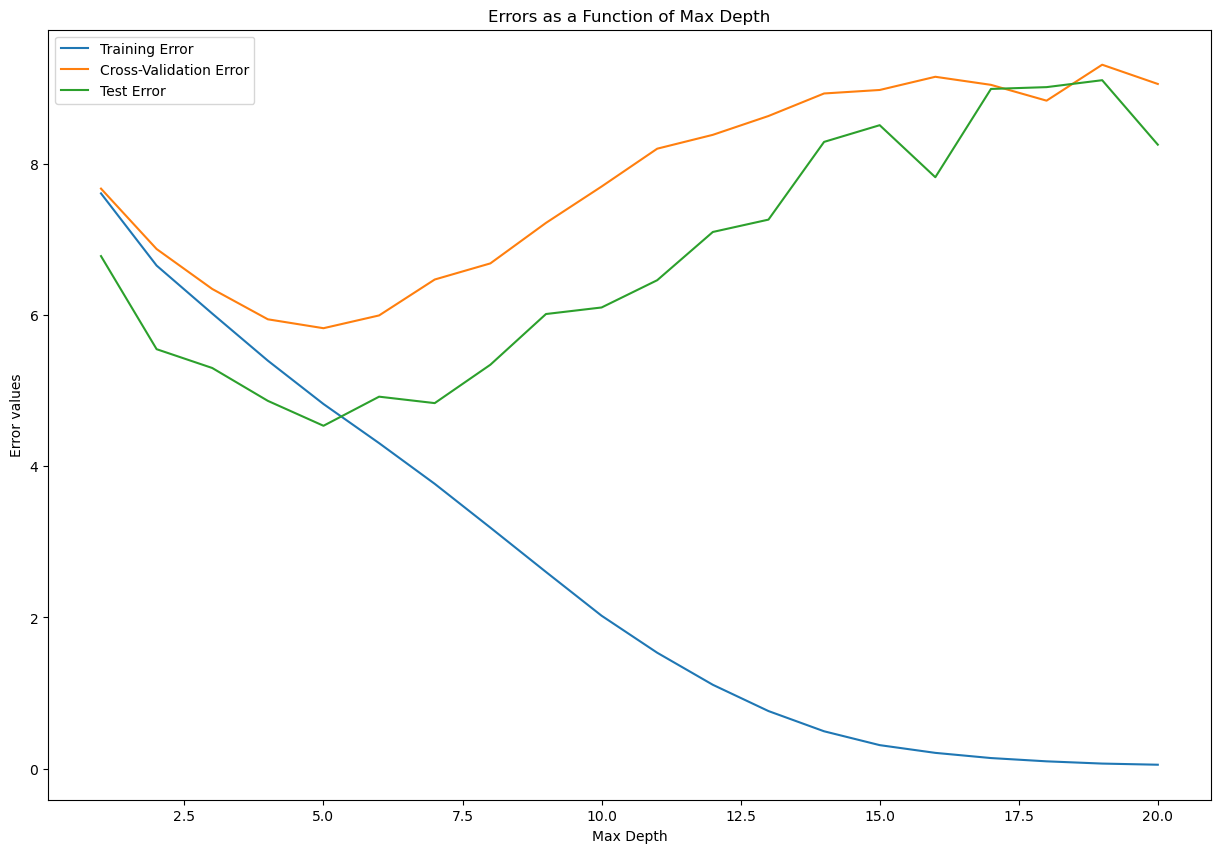

In [17]:
# Initialize lists to store errors
train_errors = []
cv_errors = []
test_errors = []

# Define a range of max_depth values to try
max_depths = list(range(1, 21))

# Loop through the max_depths and train the models
for max_depth in max_depths:
    # Create a Decision Tree Regressor with the current max_depth
    dt_regressor_depth = DecisionTreeRegressor(max_depth=max_depth, random_state=123)

    # Fit the model on the training set
    dt_regressor_depth.fit(x_train, y_train)
    
    # Calculate the training error
    train_error = mean_squared_error(y_train, dt_regressor_depth.predict(x_train))
    train_errors.append(train_error)

    # Calculate the cross-validation error
    cv_error = -np.mean(cross_val_score(dt_regressor_depth, x_train, y_train, cv=3, scoring='neg_mean_squared_error'))
    cv_errors.append(cv_error)

    # Calculate the test error
    test_error = mean_squared_error(y_test, dt_regressor_depth.predict(x_test))
    test_errors.append(test_error)

# Plot the errors as a function of max_depth
plt.figure(figsize=(15, 10))
plt.plot(max_depths, train_errors, label='Training Error')
plt.plot(max_depths, cv_errors, label='Cross-Validation Error')
plt.plot(max_depths, test_errors, label='Test Error')
plt.xlabel('Max Depth')
plt.ylabel('Error values')
plt.legend()
plt.title('Errors as a Function of Max Depth')
plt.show()

### 3.2 Errors as Function of Min Samples Leaf
---
Here the same errors as in section <i>3.1</i> are calculated using the best max_depth calculated in the above section of 6. Then values of min_samples_leaf are used along with 3-fold cross-validation values to tune the value of min_samples_leaf. <br> Unlike in the above section initially the training error increases constantly as the min_samples_leaf increases. <br> This is to be expected as when the value of min_samples_leaf increases the model becomes less flexible as the samples in each node need to be higher and higher for a split to occur. The cross validation error initially decreases as the model becomes less flexible and accounts for less outliers and noise this trend is also seen in the testing error. <br> However at around min_samples_leaf = 50 the testing error and cross-validation error bottom out and increase as min_samples_leaf increases. I believe this is due to the fact that at this point the model is capturing the underlying trend well and any increase to min_samples_leaf prevents the model from capturing the trend by making it harder and harder to split nodes. <br> Based off of this graph I would choose min_samples_leaf = 50 as it minimises the testing and cross validation error.

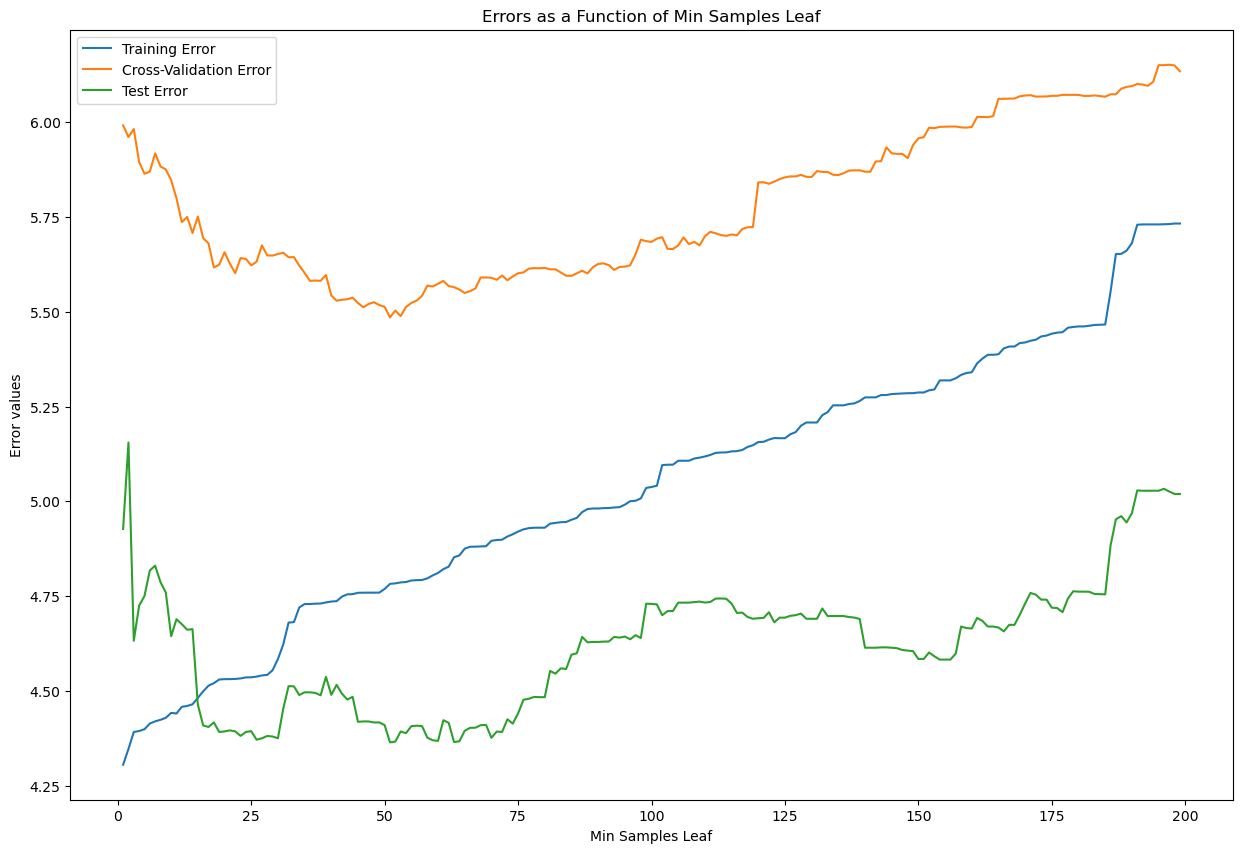

In [18]:
# Set the max_depth value obtained from the previous task
best_max_depth = 6

# Create a range of min_samples_leaf values to test
min_samples_leaf_range = np.arange(1, 200)

# Initialize lists to store errors
train_errors = []
cv_errors = []
test_errors = []

# Loop through min_samples_leaf values
for min_samples_leaf in min_samples_leaf_range:
    dt_regressor_leaf = DecisionTreeRegressor(max_depth=best_max_depth, min_samples_leaf=min_samples_leaf, random_state=123)
    
    # Calculate training error
    dt_regressor_leaf.fit(x_train_scaled, y_train)
    y_train_pred = dt_regressor_leaf.predict(x_train_scaled)
    train_error = mean_squared_error(y_train, y_train_pred)
    train_errors.append(train_error)
    
    # Calculate cross-validation error
    cv_scores = cross_val_score(dt_regressor_leaf, x_train_scaled, y_train, scoring='neg_mean_squared_error', cv=3)
    cv_error = -np.mean(cv_scores)
    cv_errors.append(cv_error)
    
    # Calculate test error
    y_test_pred = dt_regressor_leaf.predict(x_test_scaled)
    test_error = mean_squared_error(y_test, y_test_pred)
    test_errors.append(test_error)

# Plot the training, cross-validation, and test errors as a function of min_samples_leaf
plt.figure(figsize=(15, 10))
plt.plot(min_samples_leaf_range, train_errors, label='Training Error')
plt.plot(min_samples_leaf_range, cv_errors, label='Cross-Validation Error')
plt.plot(min_samples_leaf_range, test_errors, label='Test Error')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Error values')
plt.legend()
plt.title('Errors as a Function of Min Samples Leaf')
plt.show()

### 3.3 Random Forest Regressor with 500 Estimators
---
Here a random forest regressor with 500 estimators is trained on the training data with the best hyperparameters found in the previous two sections. Then the RMSE of this model is calculated to be ~2.24. <br> The hyperparameters of max_samples, max_features and bootstrap were chosen based off of the sklearn documentation where an 80 percent max sample and features seemed like a good tradeoff between retaining enough data in the testing set and having a large diverse set of the training data to train each estimator on. Setting bootstrap to true allows for replacement which is standard practice.

In [19]:
# Set the selected max_depth and min_samples_leaf values
best_max_depth = 6
best_min_samples_leaf = 50

# Initialize the Random Forest regressor
rf_regressor = RandomForestRegressor(n_estimators=500, max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, max_samples=0.8, max_features=0.8, bootstrap=True, random_state=123)

# Fit the regressor to the training data
rf_regressor.fit(x_train_scaled, y_train)

# Predict the test set values and round them to the nearest integer
y_test_pred_rounded = np.round(rf_regressor.predict(x_test_scaled))

# Calculate the RMSE
rmse_test = (mean_squared_error(y_test, y_test_pred, squared=False))

print(f'Random Forest Regressor Test RMSE: {rmse_test}')

Random Forest Regressor Test RMSE: 2.240375792825694


### 3.4 Feature Dimension Reduction
---
The feature dimension of the data is trimmed by finding the feature importances with the selectfrommodel function from sklearn. This function is applied to the testing and training datasets and then used to get the features that will be retained. The features that are retained are those with an importance value above 5%. <br> The features that were retained are as follows.
- Shucked weight
- Shell weight
- Height
- Viscera weight


These were the only features with an importance value above 5% and as a result are the only retained features this resulted in a total feature importance value retained of ~0.90. <br> <i>(*Note these values seem to change every time I close the kernel and re run the code but they are always around the same features with sometimes height and viscera weight being removed and an importance of between 0.89-0.94)

In [20]:
# Get the feature importances from the trained Random Forest regressor
feature_importances = rf_regressor.feature_importances_

# Use SelectFromModel to retain features with importance values above 0.05
selector = SelectFromModel(rf_regressor, threshold=0.05, prefit=True)

# Apply the selection to the training and test sets
x_train_selected = selector.transform(x_train_scaled)
x_test_selected = selector.transform(x_test_scaled)

# Get the indices of retained features
selected_features = selector.get_support()

# List retained and removed features
retained_features = x.columns[selected_features]
removed_features = x.columns[~selected_features]

# Calculate the total feature importance value retained
total_importance_retained = feature_importances[selected_features].sum()

print("Retained features:", retained_features.values)
print("Removed features:", removed_features.values)
print(f"Total feature importance value retained: {total_importance_retained}")

Retained features: ['Height' 'Shucked weight' 'Viscera weight' 'Shell weight']
Removed features: ['Length' 'Diameter' 'Whole weight']
Total feature importance value retained: 0.9018510296061586


### 3.5 Reduced Feature Dimension Random Forest Regressor
---
The reduced feature dimension dataset from section <i>3.4</i> is used to train a new random forest regressor with 500 estimators and the same hyperparameters as in section <i>3.3</i>. The predictions of this new reduced feature dimension regressor are calculated and then rounded to the nearest integer and a RMSE of ~2.07 is calculated. <br> This is a slight reduction in RMSE from 2.24 down to ~2.07, this is unexpected as a reduction in feature importance should cause an increase in the RMSE. Originally this is what was happening but when I closed the kernel and rerun the code I started getting a reduction that I'm not entirely sure about. I suspect that if I tuned the manually selected hyperparameters It could fix this <br> <i> (*Note this is another value that seems to fluctuate every time I close the kernel and rerun the code but its always around 2.03-2.09)

In [21]:
# Train the Random Forest regressor on the reduced-dimensional data
rf_regressor_reduced = RandomForestRegressor(n_estimators=500, max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, max_samples=0.8, max_features=0.8, bootstrap=True, random_state=123)
rf_regressor_reduced.fit(x_train_selected, y_train)

# Make predictions on the test set
y_pred_reduced = rf_regressor_reduced.predict(x_test_selected)

# Round the predictions to the nearest integer
y_test_pred_reduced_rounded = np.round(y_pred_reduced)

# Calculate the RMSE for the reduced-dimensional data
rmse_reduced = mean_squared_error(y_test, y_test_pred_reduced_rounded, squared=False)

print(f"RMSE for the reduced-dimensional data: {rmse_reduced:}")

RMSE for the reduced-dimensional data: 2.0269319057526856


### 3.6 Comparison of Performance with Diagram
---
We calculate the absolute errors for both models and then calculate and plot the aberage error and instance count per ring value to get an understanding of where the errors are coming from. <br> In the average prediction error per ring value plot it can be seen that the average prediction error varies per ring value with higher prediction errors for both models occuring as the ring value approaches the extremities of the range with the small and large ring values having higher than the middle range average prediction error. The highest average predicted error is at the large ring values. <br> This discrepancy of the average prediction error can be explained when looking at the instances of each ring value graph below. In this plot it can be seen that the vast majority of the instances for each ring value falls between 5 and 15. This is where the least average prediction error lies and as a result the models are most accurate in this range. <br> This means that it is likely that the large prediction error for a ring value is closely related to the number of training instances for that ring value. In this case it seems that the large average prediction error observed in large ring values and small ring values is due to insufficient training instances for that ring value

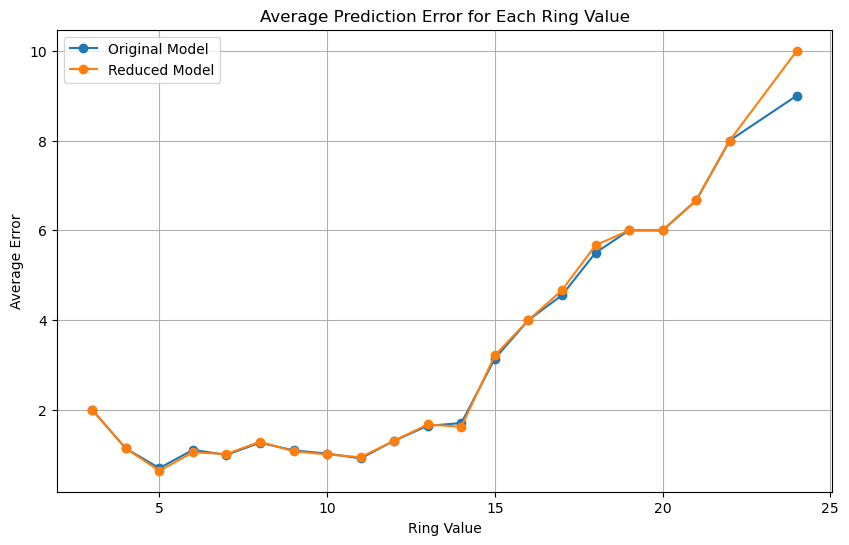

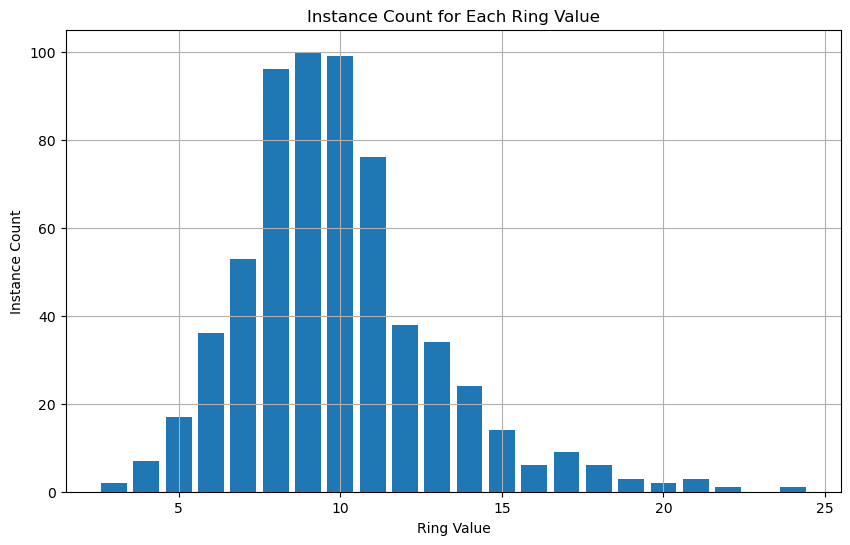

In [22]:
# Compute the absolute errors for both models
abs_errors_original = np.abs(y_test - y_test_pred_rounded)
abs_errors_reduced = np.abs(y_test - y_test_pred_reduced_rounded)

# Create a DataFrame to store the ring values, absolute errors, and instance count for both models
error_comparison_df = pd.DataFrame({'Ring Value': y_test, 'Original Model Error': abs_errors_original, 'Reduced Model Error': abs_errors_reduced})
error_comparison_df['Count'] = 1

# Calculate the average error and instance count for each ring value
average_error_per_ring = error_comparison_df.groupby('Ring Value').agg({'Original Model Error': 'mean', 'Reduced Model Error': 'mean', 'Count': 'count'}).reset_index()

# Plot the average prediction error for each ring value
plt.figure(figsize=(10, 6))
plt.plot(average_error_per_ring['Ring Value'], average_error_per_ring['Original Model Error'], label='Original Model', marker='o')
plt.plot(average_error_per_ring['Ring Value'], average_error_per_ring['Reduced Model Error'], label='Reduced Model', marker='o')
plt.xlabel('Ring Value')
plt.ylabel('Average Error')
plt.legend()
plt.title('Average Prediction Error for Each Ring Value')
plt.grid()
plt.show()

# Plot the instance count for each ring value
plt.figure(figsize=(10, 6))
plt.bar(average_error_per_ring['Ring Value'], average_error_per_ring['Count'])
plt.xlabel('Ring Value')
plt.ylabel('Instance Count')
plt.title('Instance Count for Each Ring Value')
plt.grid()
plt.show()

### 3.7 Bagging Regressor
---
Here a bagging regressor model is trained on the full feature dimensioned training data with the same hyperparameters as the random forest regressor in section <i>3.3</i>. The RMSE of this model is then calculated to be ~2.14. <br> Then the predicted ring values from the bagging regressor is plotted against the ground truth values, it can be seen in this plot that the model is relatively accurate predicting most of the ground truth values closely. However the model seems to struggle with ground truth values that are on the extreme of the range. <br> I suspect if we did a similar analysis to section <i>3.6</i> above and looked at the distribution of the instances we could gather whether or not this issue is due to insufficient training instances for the extreme ring values.

Bagging Regressor with SVM RMSE: 2.14


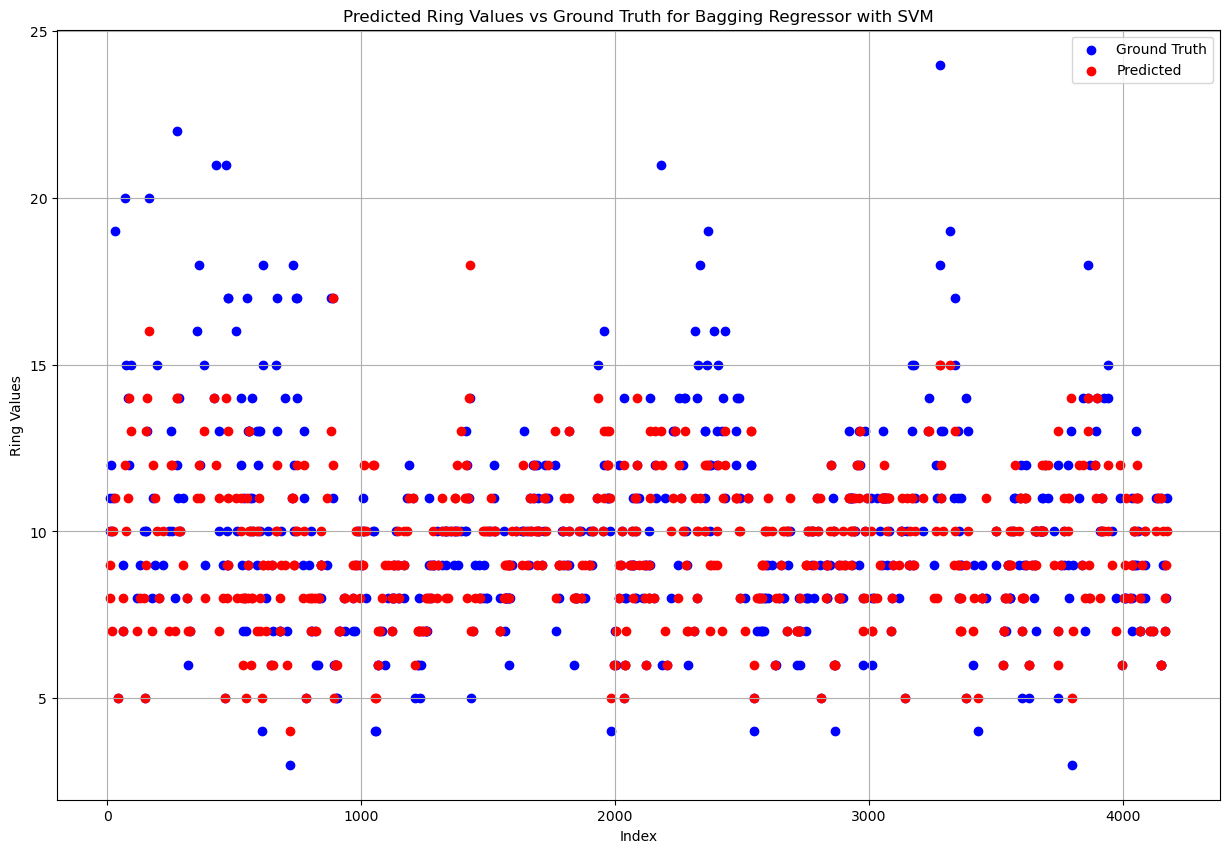

In [23]:
# Create the base estimator - SVM regressor
base_svm = SVR(kernel='linear', C=1, epsilon=0.1)

# Create the Bagging Regressor
bagging_svm = BaggingRegressor(estimator=base_svm, n_estimators=500, max_samples=0.8, max_features=0.8, bootstrap=True, random_state=123, n_jobs=-1)

# Train the Bagging Regressor
bagging_svm.fit(x_train_scaled, y_train)

# Predict the ring values for the test set
y_pred_bagging_svm = bagging_svm.predict(x_test_scaled)

# Round the predicted ring values to the nearest integer
y_pred_bagging_svm_rounded = np.round(y_pred_bagging_svm)

# Compute the RMSE for the test set predictions
rmse_bagging_svm = mean_squared_error(y_test, y_pred_bagging_svm_rounded, squared=False)
print(f"Bagging Regressor with SVM RMSE: {rmse_bagging_svm:.2f}")

plt.figure(figsize=(15, 10))
plt.scatter(y_test.index, y_test, label='Ground Truth', color='blue')
plt.scatter(y_test.index, y_pred_bagging_svm_rounded, label='Predicted', color='red')
plt.xlabel('Index')
plt.ylabel('Ring Values')
plt.title('Predicted Ring Values vs Ground Truth for Bagging Regressor with SVM')
plt.legend()
plt.grid()
plt.show()

### 3.8 First Random Forest Regressor vs Bagging Regressor
---
The original random forest regressor trained in section <i>3.3</i> had an RMSE of 2.24 where as the bagging regressor had an RMSE of 2.14. Although it looks like the bagging regressor is better based off of the RMSE values if we did a more in depth analysis its possible that the original random forest regressor could be better suited. <br> This could make sense however as a bagging regressor can be used as a way to reduce the variance of black box estimators like the random forest decision tree model.